# Init

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import sklearn.cluster

import sys
# sys.path.remove('/home/users/pjh/scripts/python_genome_packages')
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev')

In [2]:
from handygenome import common
from handygenome.common import ChromDict, Interval
from handygenome.variant.vcfspec import Vcfspec

from handygenome.sv.breakends import Breakends
from handygenome.variant.variantplus import VariantPlus, VariantPlusList
import handygenome.variant.variantplus as libvp
# from handygenome.variant.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

[W::hts_idx_load3] The index file is older than the data file: /home/users/pjh/scripts/python_genome_packages/data/popfreq/dbSNP_b155_GRCh37.p13.vcf.gz.csi


In [3]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

In [4]:
from handygenome.cnv import sequenza_handler
from handygenome.cnv import read_cnvfile
from handygenome.cnv import inspect_cnv
from handygenome.cnv import misc as cnvmisc

In [5]:
igv = IGVHandle(60387)

# Setups

In [6]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_FORDEPTH_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged_window50.bed'
PANEL_REGION_WITHGENENAME_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged_WithGeneName.bed'

PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.woheader.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.woheader.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

PANEL_REGION_GR = pr.read_bed(PANEL_REGION_PATH)
PANEL_REGION_FORDEPTH_GR = pr.read_bed(PANEL_REGION_FORDEPTH_PATH)
PANEL_REGION_WITHGENE_GR = pr.read_bed(PANEL_REGION_WITHGENENAME_PATH)

In [7]:
sampletype_filename_map = {
    'tumor': ['tumor'], 
    'normal': ['normal'], 
    'panel': ['panel'], 
    'rna': ['RNA', 'RNA_GFP'],
}
BAM_PATHS = {sampletype: dict() for sampletype in sampletype_filename_map.keys()}

for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype, fname_portions in sampletype_filename_map.items():
                if f in (f'{sampleid}.{fname_portion}.bam' for fname_portion in fname_portions):
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [8]:
BAMS = {
    sampletype: {
        sampleid: pysam.AlignmentFile(bampath) 
        for sampleid, bampath in bampathdic.items()
    }
    for sampletype, bampathdic in BAM_PATHS.items()
}

In [9]:
_sampleid_keys = ['LU-14', 'LU-6', 'LU-87', 'LU-F13', 'LU-F2', 'LU-F33', 'LU-F37', 'LU-FF1', 'LU-FF104', 'LU-FF115', 'LU-FF13', 'LU-FF18', 'LU-FF20', 'LU-FF21', 'LU-FF23', 'LU-FF24', 'LU-FF27', 'LU-FF3', 'LU-FF31', 'LU-FF34', 'LU-FF37', 'LU-FF39', 'LU-FF4', 'LU-FF43', 'LU-FF53', 'LU-FF56', 'LU-FF57', 'LU-FF58', 'LU-FF6', 'LU-FF62', 'LU-FF67', 'LU-FF71', 'LU-FF76', 'LU-FF77', 'LU-FF78', 'LU-FF79', 'LU-FF80', 'LU-FF85', 'LU-IO04', 'LU-IO05', 'LU-IO06', 'LU-IO07', 'LU-IO08', 'LU-IO09', 'LU-IO12', 'LU-IO13', 'LU-IO15', 'LU-IO16', 'LU-IO17', 'LU-IO18', 'LU-IO22', 'LU-IO23', 'LU-IO24', 'LU-IO25', 'LU-SC126', 'LU-SC134', 'LU-SC31', 'LU-SC81', 'LU-SC88', 'LU-SC97', 'LU-SC98',]

PREVIOUS_PURITY = dict(zip(
    _sampleid_keys,
    [0.31, 0.16, 0.24, 0.75, 0.28, 0.5, 0.34, 0.17, 0.45, 0.43, 0.21, 0.86, 0.32, 0.37, 0.35, 0.5, 0.48, 0.2, 0.11, 0.19, 0.75, 0.21, 0.15, 0.34, 0.33, 0.37, 0.21, 0.14, 0.47, 0.52, 0.28, 0.11, 0.54, 0.27, 0.36, 0.36, 0.28, 0.24, 0.1, 0.36, 0.23, 0.24, 0.65, 0.31, 0.49, 0.69, 0.41, 0.32, 0.5, 0.42, 0.57, 0.11, 0.2, 0.28, 0.11, 0.4, 0.22, 0.4, 0.13, 0.15, 0.51,],
))

PREVIOUS_PLOIDY = dict(zip(
    _sampleid_keys,
    [2.6, 2.3, 2.7, 2.4, 1.9, 4.8, 1.9, 2.7, 2, 1.9, 2.9, 2.6, 4.5, 2.9, 2.8, 3.6, 2.1, 2.5, 2.3, 2, 2.4, 2, 2.6, 4.1, 5.7, 2.7, 3.45, 2.3, 2.1, 3.5, 2.2, 2.3, 2, 2.2, 2.9, 2, 2.2, 2.8, 2.1, 2.7, 2.4, 4.5, 2.3, 3.1, 3.5, 3.5, 5.3, 1.9, 3.3, 2.1, 2.9, 1.8, 4.4, 3.3, 2.4, 3.1, 3.7, 3.3, 1.6, 2.5, 1.9,],
))

MEAN_DEPTH_WGS_NORMAL = dict(zip(
    _sampleid_keys,
    [37.3767, 34.0972, 33.8064, 32.7928, 35.8954, 50.7577, 35.2345, 44.4876, 31.9701, 32.5393, 29.2703, 35.8483, 30.652, 30.3674, 30.7484, 37.0206, 32.9964, 32.02, 44.0783, 31.1997, 35.246, 25.3979, 27.8882, 32.5782, 32.0687, 29.2798, 35.0811, 31.21, 31.6326, 30.6922, 34.1979, 36.7596, 46.6577, 31.1763, 33.2672, 30.7369, 49.3219, 39.396, 50.6684, 47.5066, 42.1341, 50.5406, 61.0353, 48.3776, 47.3945, 47.8588, 53.5356, 50.1395, 51.1773, 48.859, 62.2889, 48.3631, 50.9241, 49.4595, 38.866, 48.8294, 60.0835, 39.58, 48.9517, 38.0445, 50.1143, ],
))

MEAN_DEPTH_WGS_TUMOR = dict(zip(
    _sampleid_keys,
    [33.8314, 28.6972, 39.9078, 31.2967, 35.1856, 50.3825, 32.995, 44.5512, 43.6843, 37.4389, 44.6266, 51.0667, 45.7373, 49.1081, 48.7203, 44.3134, 39.4903, 43.6447, 43.191, 46.8438, 32.9415, 43.3598, 47.5503, 48.4404, 47.5455, 42.8442, 36.943, 30.8365, 46.2036, 45.757, 46.2073, 41.2358, 32.9015, 38.2982, 37.7461, 35.5173, 47.0067, 50.212, 47.7919, 49.4914, 40.2729, 48.2904, 48.8819, 49.3573, 48.2809, 48.1625, 46.9765, 48.5246, 47.191, 57.4008, 45.9216, 61.224, 58.4995, 54.2237, 39.9667, 46.8006, 46.7105, 29.9816, 46.1059, 35.9943, 59.4945,],
))

MEAN_DEPTH_PANEL = dict(zip(
    _sampleid_keys,
    [925.555, 828.655, 1056.57, 949.034, 658.752, 943.504, 865.002, 1005.13, 1017.37, 928.113, 704.835, 1038.69, 841.098, 796.267, 861.94, 1199.86, 982.991, 622.94, 755.689, 883.229, 763.161, 994.175, 832.632, 886.978, 870.606, 940.946, 1123.63, 973.926, 867.741, 930.398, 983.845, 933.354, 992.087, 1019.04, 1027.85, 875.693, 860.521, 864.663, 934.823, 894.882, 1150.48, 866.108, 1018.39, 961.328, 1079.97, 792.767, 793.318, 362.512, 858.098, 1006.79, 1154.51, 837.199, 786.832, 1094.11, 689.674, 798.415, 1001.33, 1079.07, 760.339, 761.318, 880.314, ],
))

PANEL_ONTARGET_RATIO = dict(zip(
    _sampleid_keys,
    [0.911, 0.872, 0.79, 0.917, 0.838, 0.761, 0.701, 0.934, 0.924, 0.913, 0.696, 0.718, 0.85, 0.905, 0.87, 0.899, 0.879, 0.66, 0.783, 0.885, 0.761, 0.912, 0.789, 0.868, 0.63, 0.74, 0.808, 0.835, 0.891, 0.698, 0.914, 0.925, 0.922, 0.91, 0.923, 0.86, 0.822, 0.795, 0.758, 0.834, 0.88, 0.926, 0.924, 0.895, 0.869, 0.842, 0.72, 0.838, 0.798, 0.871, 0.91, 0.872, 0.826, 0.904, 0.858, 0.84, 0.881, 0.929, 0.806, 0.831, 0.867, ],
))

GENDER = dict(zip(
    _sampleid_keys,
    ['M', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M',]
))
IS_FEMALE = {key: (val == 'F') for key, val in GENDER.items()}

# My own panel CNV caller

### Load modules

In [11]:
import handygenome.cnv.mosdepth as libmosdepth
import handygenome.cnv.misc as cnvmisc
import handygenome.cnv.sequenza_handler as sequenza_handler

### Define functions

In [13]:
def make_coord_converters(plotting_panel_region_gr):
    coord_converters = dict()
    cumsum = 0
    for chrom, subgr in plotting_panel_region_gr.items():
        current_cumsum = subgr.lengths().cumsum()
        offsets = (current_cumsum.shift(1, fill_value=0) + cumsum).array
        cumsum += current_cumsum.iloc[-1]
        index = pd.IntervalIndex.from_breaks(
            (list(subgr.Start) + [subgr.End.iloc[-1]]), 
            closed='left',
        )

        coord_converters[chrom] = pd.Series(data=offsets, index=index)
        
    return coord_converters

In [14]:
def convert_coord(chrom, pos0, coord_converters):
    hit_indexes = np.where(coord_converters[chrom].index.contains(pos0))[0]
    if len(hit_indexes) == 0:
        return None
    
    idx = hit_indexes[0]
    intv = coord_converters[chrom].index[idx]
    offset = coord_converters[chrom].iloc[idx]
    return offset + (pos0 - intv.left)

In [15]:
def prepare_cnvkit_grs(cnsfile_path, cnrfile_path, callfile_path):
    cnvkit_segment_df = pd.read_csv(cnsfile_path, sep='\t', header=0)
    cnvkit_segment_df = cnvkit_segment_df.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
    cnvkit_segment_df['seg_depthratio'] = 2 ** cnvkit_segment_df['log2']
    cnvkit_segment_df['seg_depthratio_ci_lo'] = 2 ** cnvkit_segment_df['ci_lo']
    cnvkit_segment_df['seg_depthratio_ci_hi'] = 2 ** cnvkit_segment_df['ci_hi']
    cnvkit_segment_gr = pr.PyRanges(cnvkit_segment_df, int64=True)

    cnvkit_cnr_df = pd.read_table(cnrfile_path, header=0)
    cnvkit_cnr_df = cnvkit_cnr_df.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
    cnvkit_cnr_df['cnr_depthratio'] = 2 ** cnvkit_cnr_df['log2']
    cnvkit_cnr_gr = pr.PyRanges(cnvkit_cnr_df, int64=True)
    cnvkit_cnr_gr = cnvkit_cnr_gr[cnvkit_cnr_gr.gene != 'Antitarget']
    
    cnvkit_call_df = pd.read_table(callfile_path, header=0)
    cnvkit_call_df = cnvkit_call_df.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
    cnvkit_call_df['depthratio'] = 2 ** cnvkit_call_df['log2']
    cnvkit_call_gr = pr.PyRanges(cnvkit_call_df, int64=True)

    return cnvkit_segment_gr, cnvkit_cnr_gr, cnvkit_call_gr


def prepare_depth_ratio(tumor_normalized_depth, tumor_mean_depth, normal_normalized_depth, normal_mean_depth, panelmode=True):
    if panelmode:
        def outliers_to_nan(norm_depths, mean_depths):
            result = np.array(norm_depths)
            result[mean_depths < 50] = np.nan
            return result
    else:
        def outliers_to_nan(norm_depths, mean_depths):
            result = np.array(norm_depths)
            result[mean_depths > 2000] = np.nan
            return result
            
    tumor_norm_depth = outliers_to_nan(tumor_normalized_depth, tumor_mean_depth)
    normal_norm_depth = outliers_to_nan(normal_normalized_depth, normal_mean_depth)
    return tumor_norm_depth / normal_norm_depth

In [16]:
def plot_panel_cnv(processed_depth_gr, merged_blood_panelseq_gr, cnvkit_segment_gr, cnvkit_cnr_gr):
    # panel_bam_path = BAM_PATHS['panel'][sampleid]
    # panel_depth_gr = libmosdepth.run_mosdepth(panel_bam_path, t=5, region_bed_path=PANEL_REGION_FORDEPTH_PATH, donot_subset_bam=True, as_gr=True)
    # panel_depth_gr = postprocess_depth_df(panel_depth_gr.df, FASTA_HG19, as_gr=True)

    # cnvkit_segment_gr, cnvkit_cnr_gr = prepare_cnvkit_grs(cnvkit_segment_path_dict[sampleid], cnvkit_cnr_path_dict[sampleid])

    depth_ratio_sequenzastyle, depth_ratio_mystyle = prepare_depth_ratios(processed_depth_gr, merged_blood_panelseq_gr)
    
    # add recalculated segment depth ratio
    recalc_depth_ratios = list()
    gr = processed_depth_gr[[]]
    gr.depthratio = list(depth_ratio_sequenzastyle)
    joined_gr = cnvkit_segment_gr.join(gr, how='left')
    for key, subdf in joined_gr.df.groupby(['Chromosome', 'Start', 'End']):
        if subdf.shape[0] == 0:
            print(key)
        recalc_depth_ratios.append(subdf['depthratio'].mean())
    cnvkit_segment_gr = cnvkit_segment_gr.copy()
    cnvkit_segment_gr.recalc_depthratios = recalc_depth_ratios
    
    # plot
    plotting_gr = pr.PyRanges(chromosomes=processed_depth_gr.Chromosome, starts=processed_depth_gr.Start, ends=processed_depth_gr.End, int64=True)
    plotting_gr.depth_ratio = list(depth_ratio_sequenzastyle)
    plotting_gr.depth_ratio_mystyle = list(depth_ratio_mystyle)
    plotting_gr.GC = list(processed_depth_gr.GC)

    plotting_gr = plotting_gr.join(cnvkit_segment_gr[[x for x in cnvkit_segment_gr.columns if x.startswith('seg_')] + ['recalc_depthratios']], how='left')
    plotting_gr = pr.PyRanges(plotting_gr.df.drop_duplicates(subset=['Chromosome', 'Start', 'End'], keep='first'), int64=True)
    plotting_gr = plotting_gr[[x for x in plotting_gr.columns if x not in ('Start_b', 'End_b')]]

    plotting_gr = plotting_gr.join(cnvkit_cnr_gr[[x for x in cnvkit_cnr_gr.columns if x.startswith('cnr_')]], how='left')
    plotting_gr = pr.PyRanges(plotting_gr.df.drop_duplicates(subset=['Chromosome', 'Start', 'End'], keep='first'), int64=True)
    plotting_gr = plotting_gr[[x for x in plotting_gr.columns if x not in ('Start_b', 'End_b')]]
    plotting_gr.cnr_depthratio = plotting_gr.cnr_depthratio.where(plotting_gr.cnr_depthratio != -1)

    # plotting
    widths = plotting_gr.End - plotting_gr.Start
    widths_cumsum = widths.cumsum()

    xmin = [0] + list(widths_cumsum.iloc[:-1])
    xmax = widths_cumsum
    x = (xmin + xmax) / 2

    fig, ax = plt.subplots(figsize=(30, 10))

    ax.set_ylim(0, pd.concat([plotting_gr.depth_ratio, plotting_gr.cnr_depthratio, plotting_gr.seg_depthratio]).max())

    ax.plot(x, plotting_gr.depth_ratio, 'o', color='tab:blue', alpha=0.1, markersize=3)
    # ax.plot(x, plotting_gr.depth_ratio_mystyle, 'o', color='tab:orange', alpha=0.1, markersize=3)
    # ax.plot(x, plotting_gr.cnr_depthratio, 'o', color='tab:red', alpha=0.2, markersize=5)
    ax.hlines(y=plotting_gr.seg_depthratio, xmin=xmin, xmax=xmax, color='tab:green', alpha=0.5, linewidth=2)
    ax.hlines(y=plotting_gr.recalc_depthratios, xmin=xmin, xmax=xmax, color='tab:red', alpha=0.5, linewidth=2)
    # ax.plot((xmin + xmax) / 2, plotting_gr.GC, linewidth=0.5, alpha=0.3)
    
    return fig

### Set panel region gr for depth calculation

In [17]:
PANEL_REGION_GR_FORDEPTH = PANEL_REGION_GR.window(100)

### Load WGS sequenza result paths - extract and segment

In [702]:
final_segments_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/26_cnv_segments/final/'
WGS_SEGMENT_PATHS = dict()
for fname in os.listdir(final_segments_topdir):
    sid = fname.split('_')[0]
    WGS_SEGMENT_PATHS[sid] = os.path.join(final_segments_topdir, fname)
    
WGS_SEGMENT_GRS = {
    sid: sequenza_handler.read_sequenza_segment(fname, as_gr=True) 
    for sid, fname in WGS_SEGMENT_PATHS.items()
}

In [710]:
extract_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/05_sequenza/'
WGS_EXTRACT_PATHS = dict()
for top, dirs, files in os.walk(extract_topdir):
    for fname in files:
        if fname.endswith('sequenza_extract.RData'):
            sid = 'LU-' + fname.split('_')[0]
            WGS_EXTRACT_PATHS[sid] = os.path.join(top, fname)

### Load CNVkit results

In [53]:
cnvkit_segment_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/18_cnvkit/results_splitbins_230104'

CNVKIT_SEGMENT_PATHS = dict()
CNVKIT_SEGMENT_CALL_PATHS = dict()
CNVKIT_CNR_PATHS = dict()
for fname in os.listdir(cnvkit_segment_topdir):
    if fname.endswith('panel.cns'):
        sid = fname.split('.')[0]
        CNVKIT_SEGMENT_PATHS[sid] = os.path.join(cnvkit_segment_topdir, fname)
    if fname.endswith('panel.call.cns'):
        sid = fname.split('.')[0]
        CNVKIT_SEGMENT_CALL_PATHS[sid] = os.path.join(cnvkit_segment_topdir, fname)
    if fname.endswith('.cnr'):
        sid = fname.split('.')[0]
        CNVKIT_CNR_PATHS[sid] = os.path.join(cnvkit_segment_topdir, fname)

### Load unmatched blood panelseq depths

In [18]:
import time

blood_panelseq_bam_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/pooled_normal'
blood_panelseq_bam_paths = dict()
for top, dirs, files in os.walk(blood_panelseq_bam_topdir):
    for f in files:
        if f.endswith('indelra.bam'):
            sid = f.split('.')[0]
            blood_panelseq_bam_paths[sid] = os.path.join(top, f)

blood_panelseq_depth_grs = dict()
for sid, bam_path in blood_panelseq_bam_paths.items():
    print(sid)
    t1 = time.perf_counter()
    blood_panelseq_depth_grs[sid], _ = libmosdepth.run_mosdepth(
        bam_path, 
        t=10, 
        # region_bed_path=PANEL_REGION_FORDEPTH_PATH, 
        region_gr=PANEL_REGION_GR_FORDEPTH, 
        donot_subset_bam=True, 
        as_gr=True,
        load_perbase=False,
    )
    t2 = time.perf_counter()
    print(t2 - t1)

S10
20.118310905992985
S6
23.974673443473876
S7
19.5231096111238
S9
22.43155592493713
S5
20.682201366871595
S8
19.562150739133358


In [19]:
gr = next(iter(blood_panelseq_depth_grs.values()))
merged_blood_panelseq_gr = pr.PyRanges(
    chromosomes=gr.Chromosome,
    starts=gr.Start,
    ends=gr.End,
    int64=True
)
merged_blood_panelseq_gr.mean_depth = sum(gr.mean_depth for gr in blood_panelseq_depth_grs.values())
merged_blood_panelseq_gr = cnvmisc.postprocess_depth_df(merged_blood_panelseq_gr.df, FASTA_HG19, as_gr=True)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Seek for optimal depth-gc binning size

In [246]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['tumor']['LU-14']
df_bin1000 = libmosdepth.run_mosdepth(bam_path, t=20, window_size=1000, donot_subset_bam=True, as_gr=False)
cnvmisc.add_gc_to_df(df_bin1000, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

In [303]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['tumor']['LU-14']
df_bin50 = libmosdepth.run_mosdepth(bam_path, t=8, window_size=50, donot_subset_bam=True, as_gr=False)
cnvmisc.add_gc_to_df(df_bin50, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

589.4892962169833


In [465]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['tumor']['LU-14']
df_bin100, _ = libmosdepth.run_mosdepth(bam_path, t=8, window_size=100, donot_subset_bam=True, as_gr=False, load_perbase=False)
cnvmisc.add_gc_to_df(df_bin100, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

423.72301060007885


In [485]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['tumor']['LU-14']
df_bin500, _ = libmosdepth.run_mosdepth(bam_path, t=8, window_size=500, donot_subset_bam=True, as_gr=False, load_perbase=False)
cnvmisc.add_gc_to_df(df_bin500, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

306.2824228364043


In [490]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['tumor']['LU-14']
df_panelregionBin50_wgsbam, _ = libmosdepth.run_mosdepth(
    bam_path, t=8, region_gr=PANEL_REGION_GR.window(50), 
    donot_subset_bam=False, as_gr=False, load_perbase=False
)
cnvmisc.add_gc_to_df(df_panelregionBin50_wgsbam, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as

18.66658386029303


In [498]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['tumor']['LU-14']
df_panelregionBin100_wgsbam, _ = libmosdepth.run_mosdepth(
    bam_path, t=8, region_gr=PANEL_REGION_GR.window(100), 
    donot_subset_bam=False, as_gr=False, load_perbase=False
)
cnvmisc.add_gc_to_df(df_panelregionBin100_wgsbam, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as

18.300421041902155


In [500]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['panel']['LU-14']
df_panelregionBin50_panelbam, _ = libmosdepth.run_mosdepth(
    bam_path, t=8, region_gr=PANEL_REGION_GR.window(50), 
    donot_subset_bam=False, as_gr=False, load_perbase=False
)
cnvmisc.add_gc_to_df(df_panelregionBin50_panelbam, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as

106.71820363216102


In [532]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['panel']['LU-14']
df_panelregionBin100_panelbam, _ = libmosdepth.run_mosdepth(
    bam_path, t=8, region_gr=PANEL_REGION_GR.window(100), 
    donot_subset_bam=False, as_gr=False, load_perbase=False
)
cnvmisc.add_gc_to_df(df_panelregionBin100_panelbam, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as

98.14373490586877


In [646]:
t1 = time.perf_counter()

bam_path = BAM_PATHS['panel']['LU-14']
df_panelregionBin500_panelbam, _ = libmosdepth.run_mosdepth(
    bam_path, t=8, region_gr=PANEL_REGION_GR.window(500), 
    donot_subset_bam=False, as_gr=False, load_perbase=False
)
cnvmisc.add_gc_to_df(df_panelregionBin500_panelbam, FASTA_HG19)

t2 = time.perf_counter()
print(t2 - t1)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as

107.08450720924884


/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)


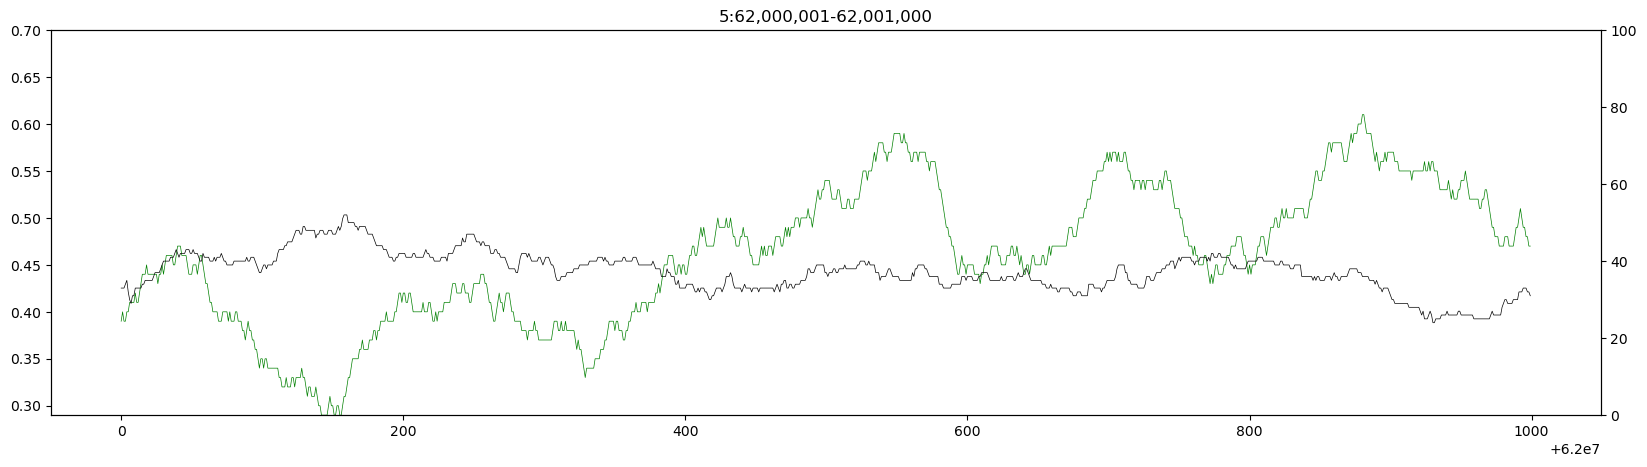

In [482]:
start0 = 62_000_000
end0 = start0 + 1000

data_gr = cnvmisc.plot_gc_depth(
    FASTA_HG19, BAM_PATHS['tumor']['LU-14'], 
    chrom='5', start0=start0, end0=end0,
    gc_window=100, xwidth=500, gc_ylims=(0.3, 0.7), depth_ylims=(0, 100),
    linewidth=0.5, alpha=1,
)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


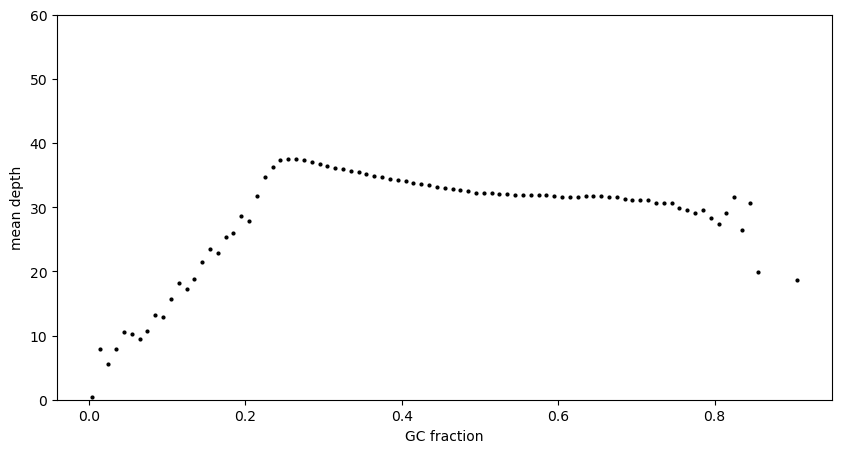

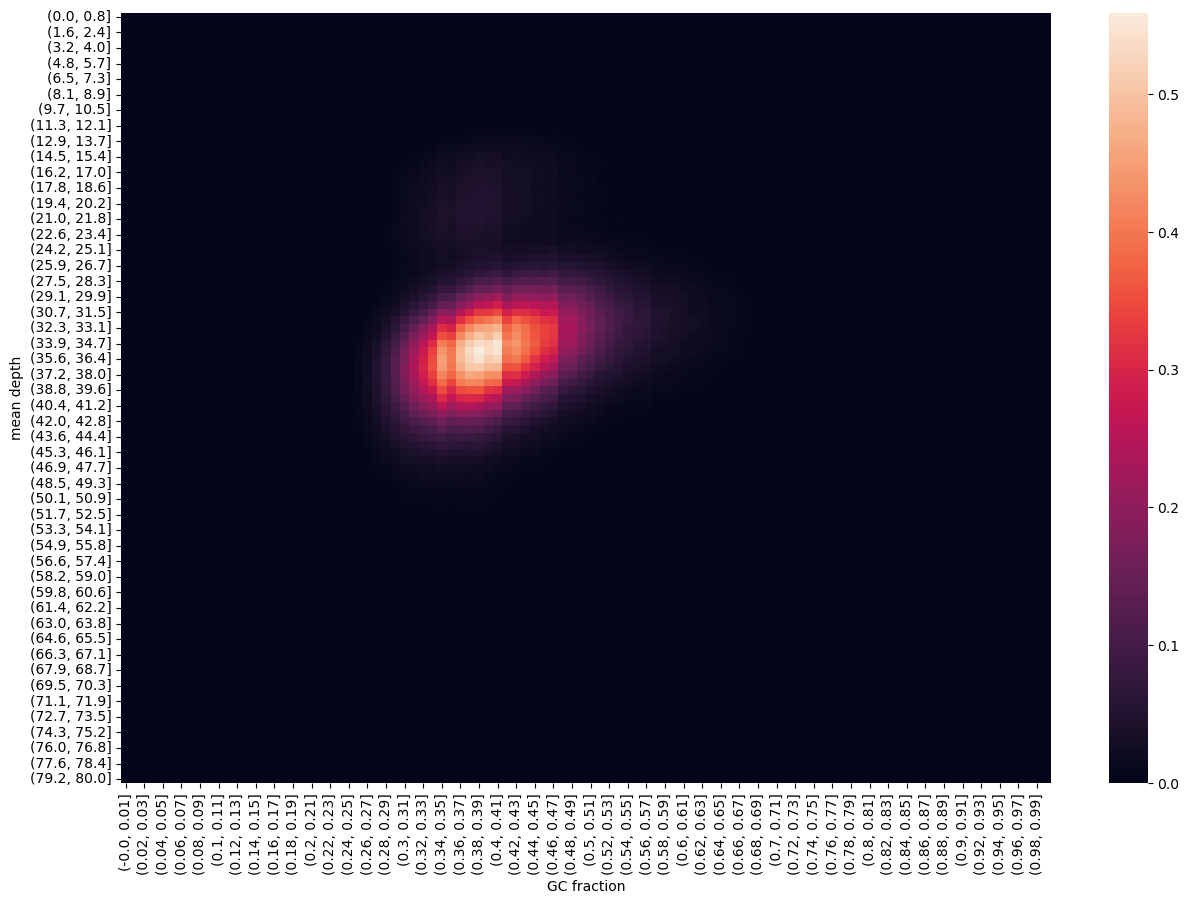

In [635]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_bin1000, trim_limits=(0, 0.01), lower_cutoff=0.01,
    scatter_ylims=(0, 60), heatmap_ylims=(0, 80), histogram_mode='2d'
)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


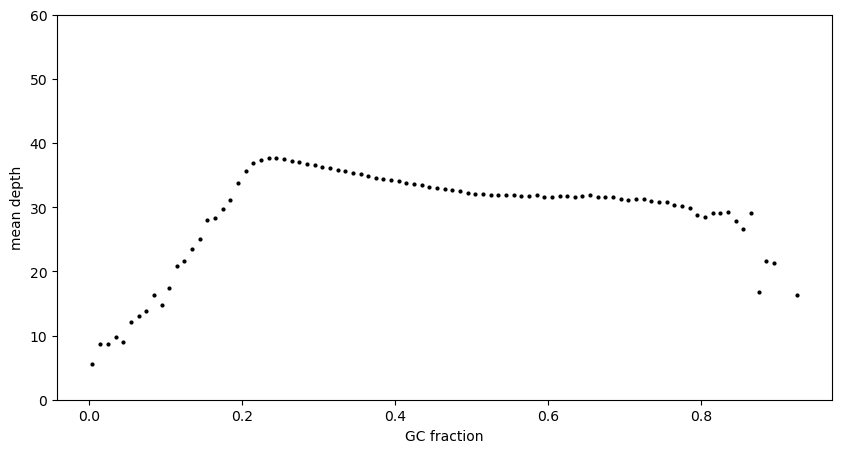

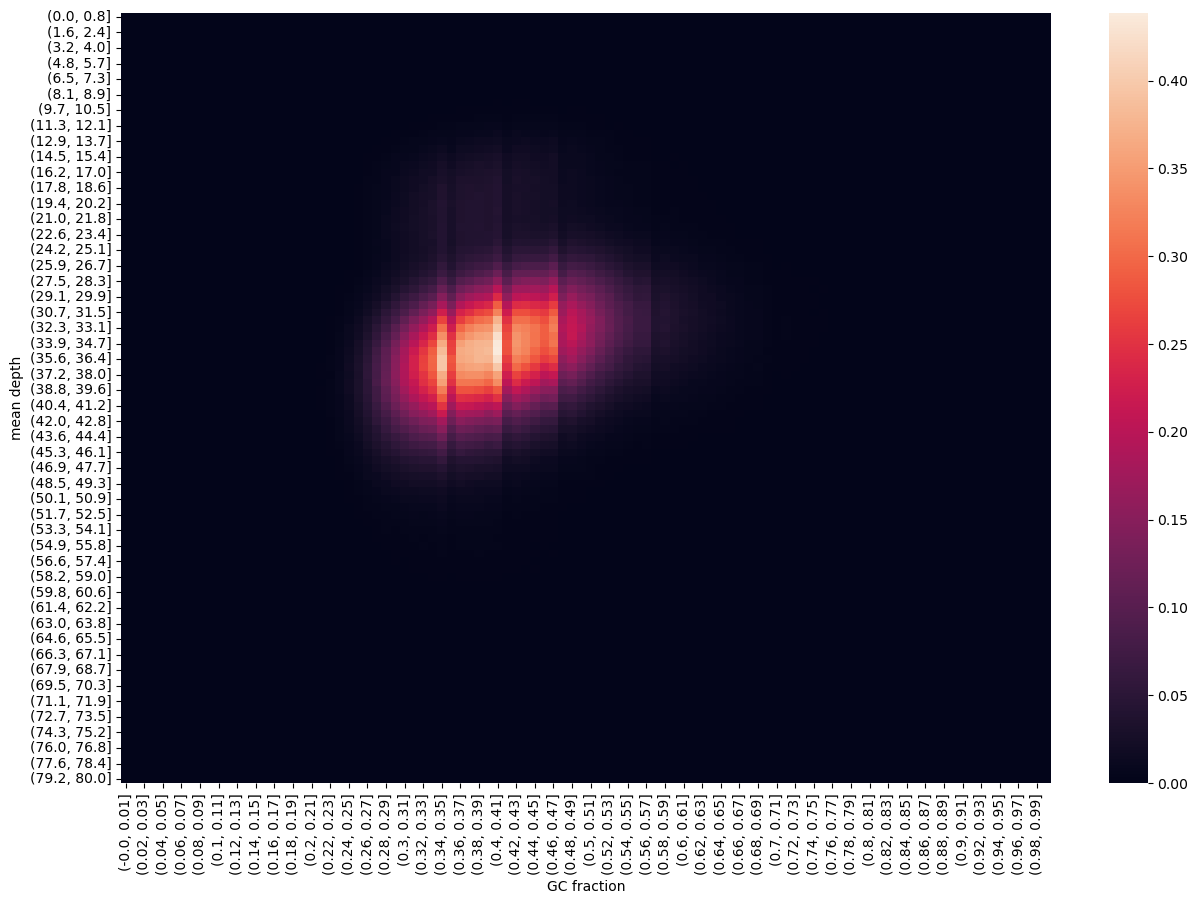

In [641]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_bin500, trim_limits=(0, 0.01), lower_cutoff=0.01,
    scatter_ylims=(0, 60), heatmap_ylims=(0, 80), heatmap_vmax=None,
    histogram_mode='2d',
)

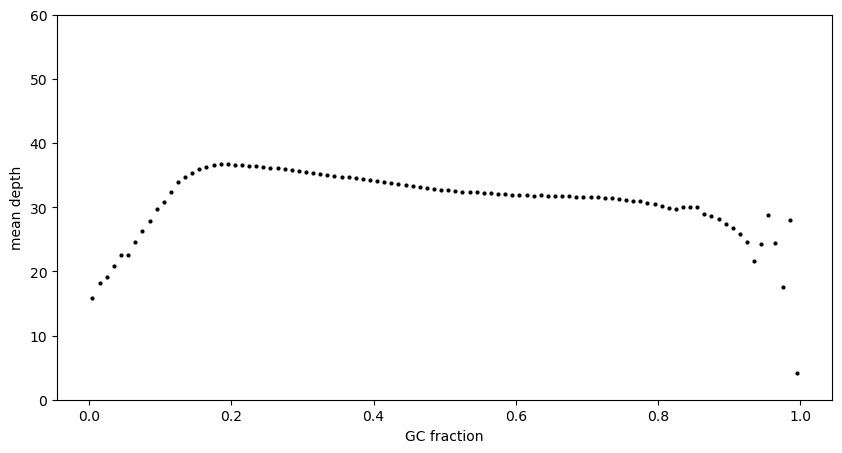

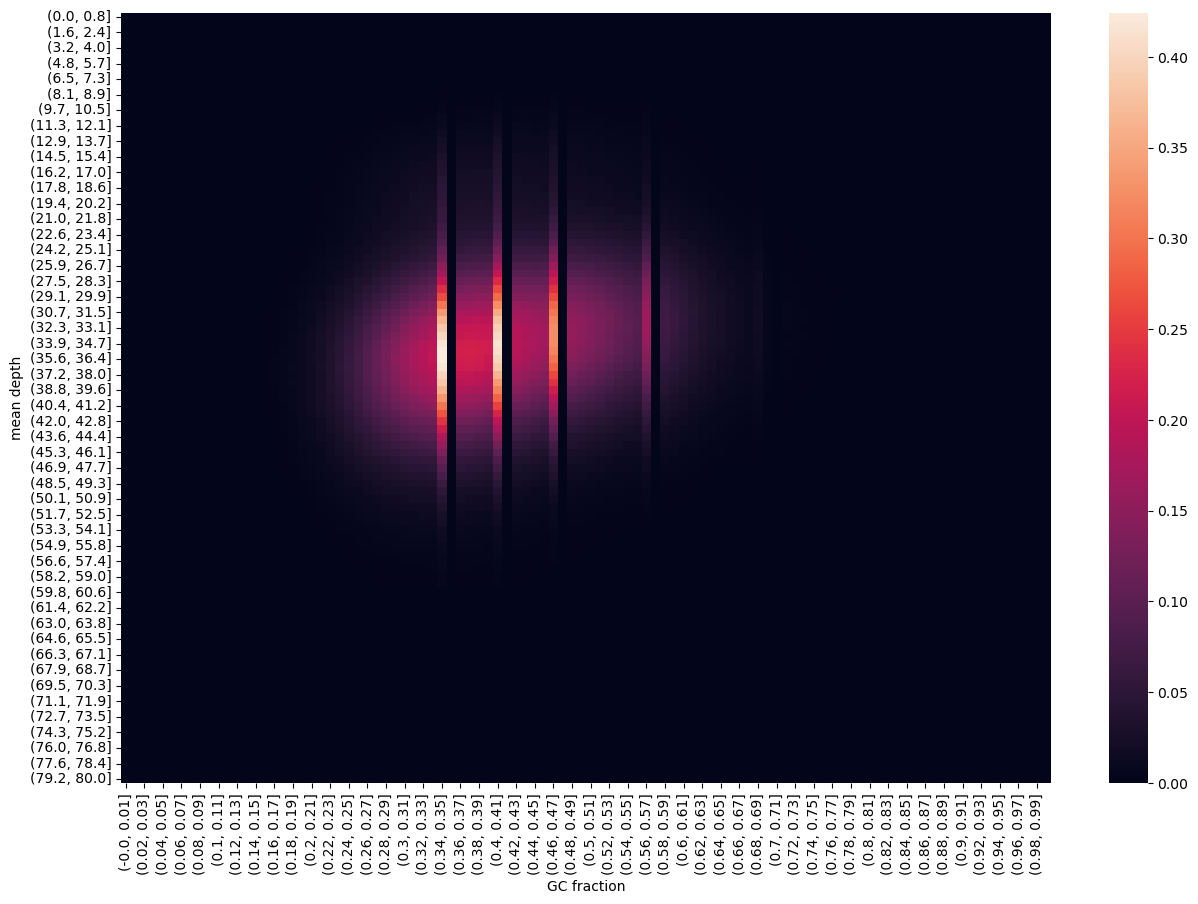

In [642]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_bin100, trim_limits=(0, 0.01), lower_cutoff=0.01,
    scatter_ylims=(0, 60), heatmap_ylims=(0, 80), heatmap_vmax=None,
    histogram_mode='2d',
)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


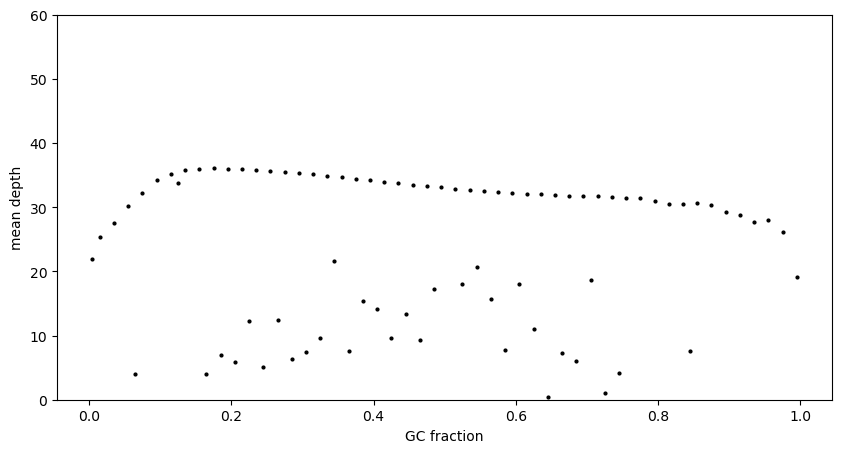

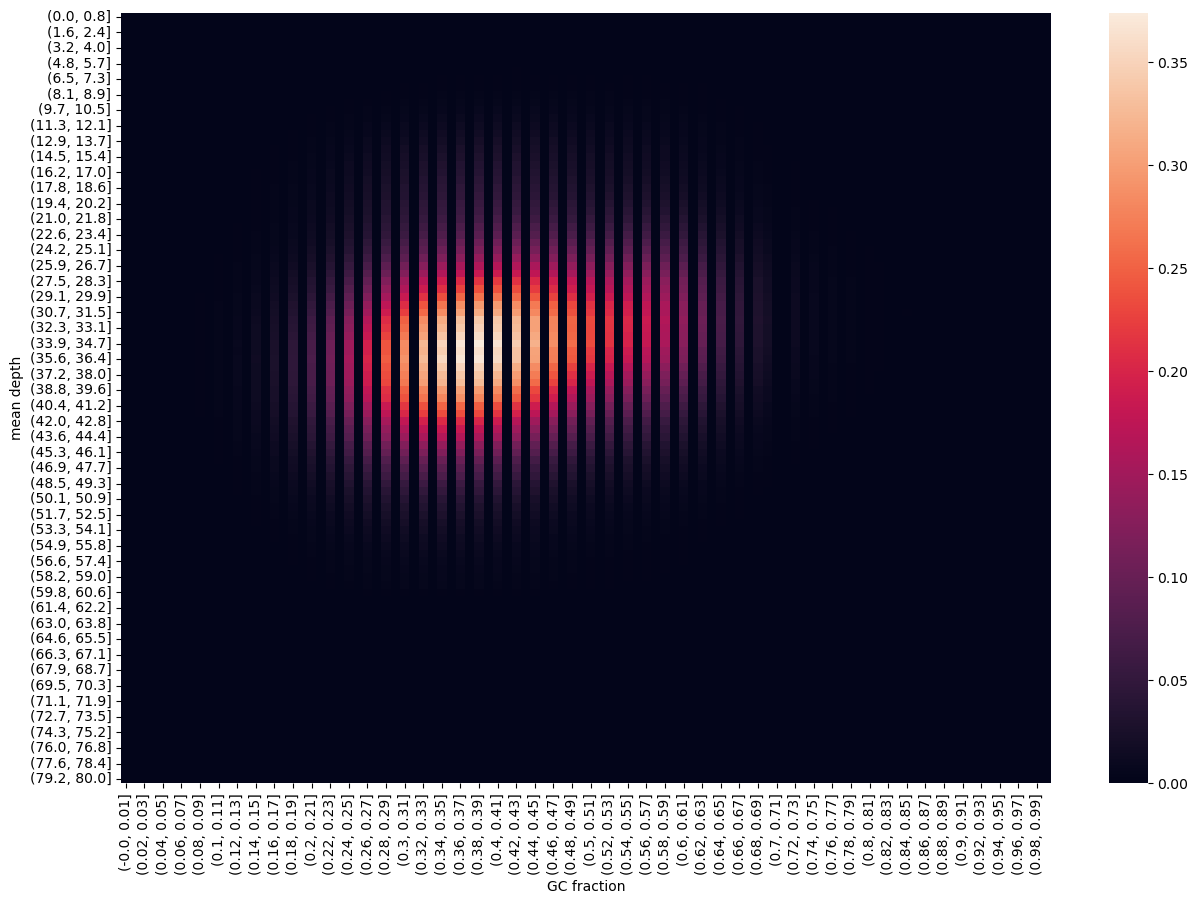

In [643]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_bin50, trim_limits=(0, 0.01), lower_cutoff=0.01,
    scatter_ylims=(0, 60), heatmap_ylims=(0, 80), heatmap_vmax=None,
    histogram_mode='2d',
)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


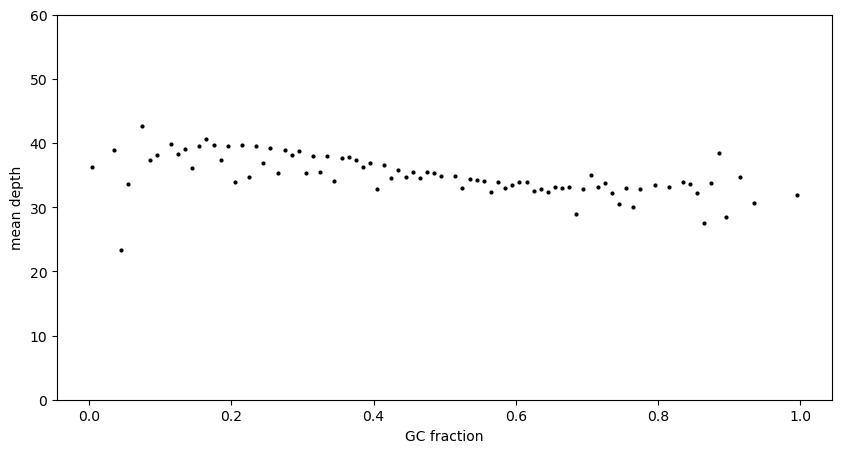

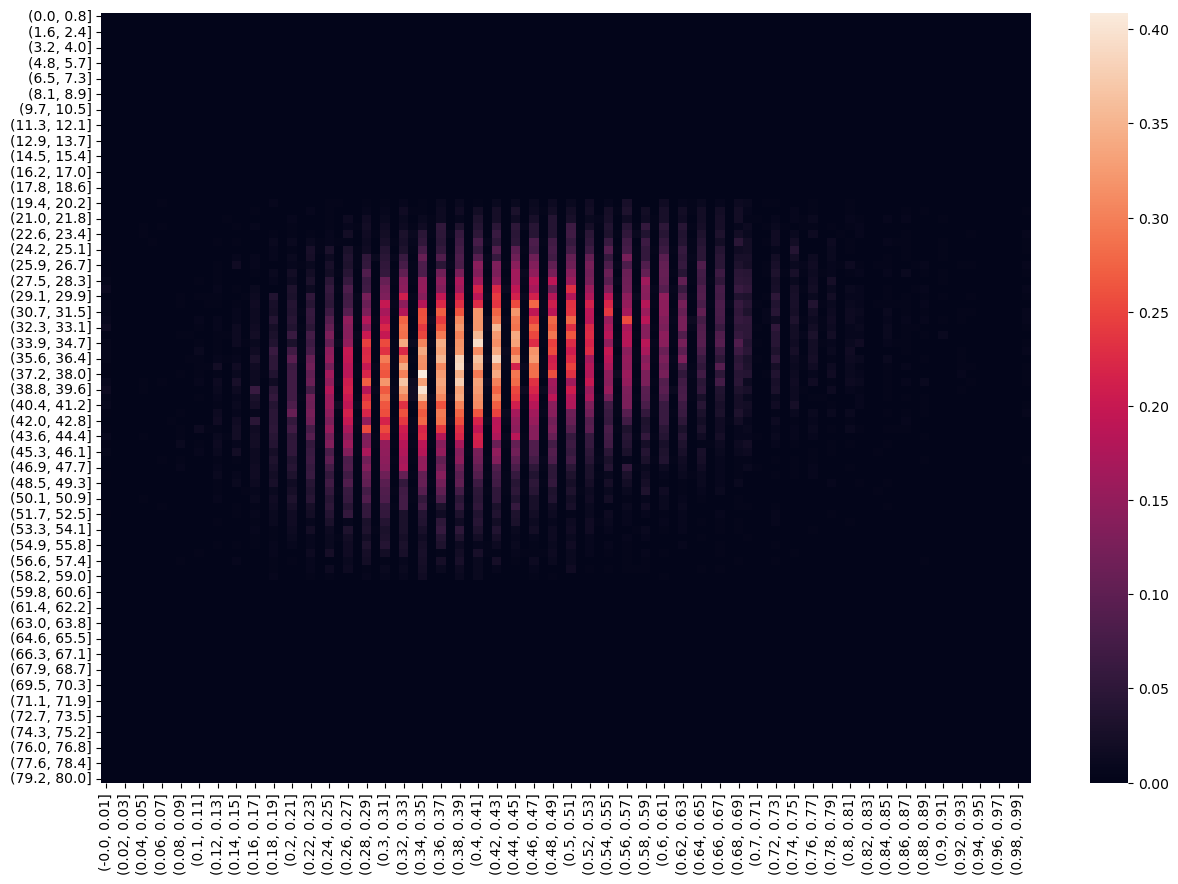

In [627]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_panelregionBin50_wgsbam, trim_limits=(0.01, 0.01), lower_cutoff=-1,
    scatter_ylims=(0, 60), heatmap_ylims=(0, 80), histogram_mode='2d'
)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


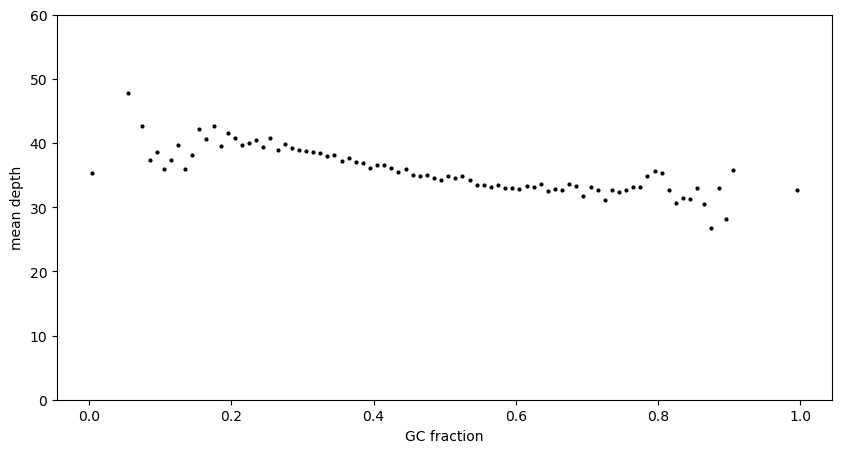

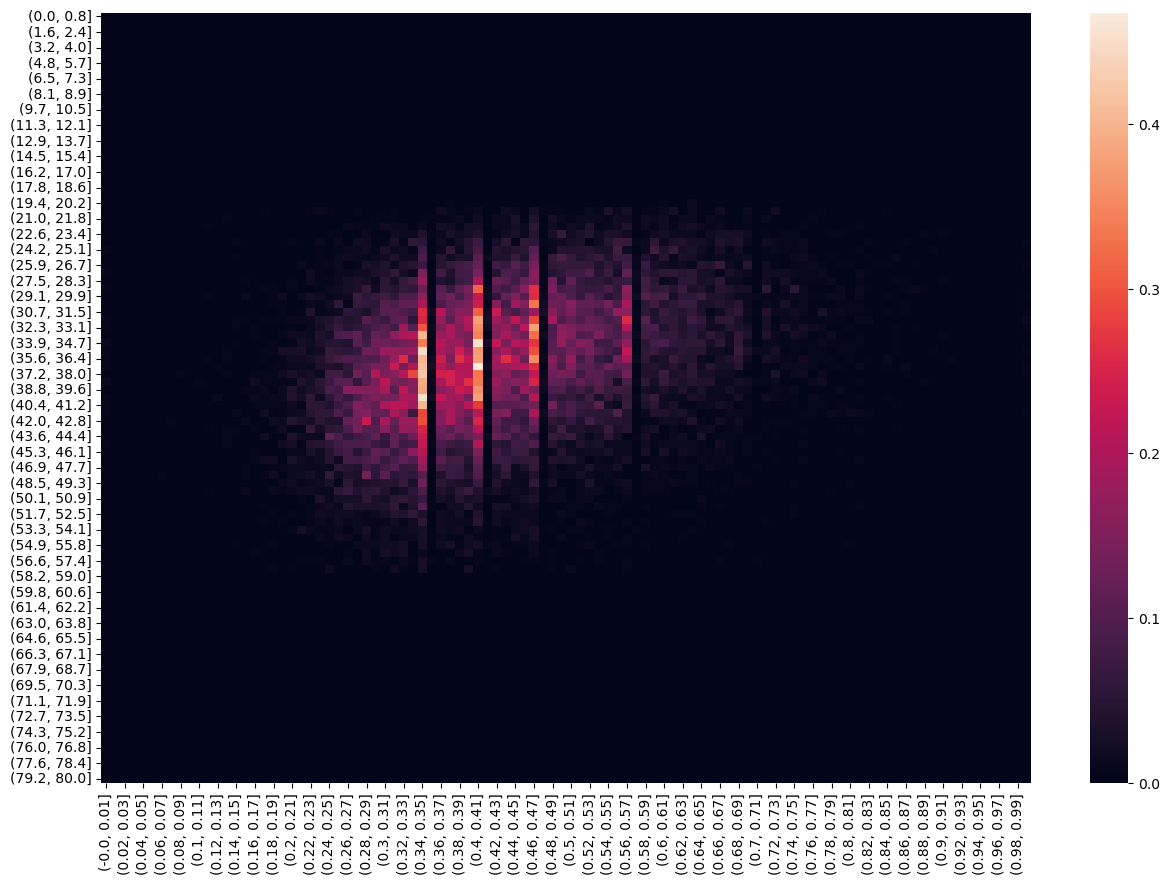

In [625]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_panelregionBin100_wgsbam, trim_limits=(0.01, 0.01), lower_cutoff=-1,
    scatter_ylims=(0, 60), heatmap_ylims=(0, 80), histogram_mode='2d'
)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


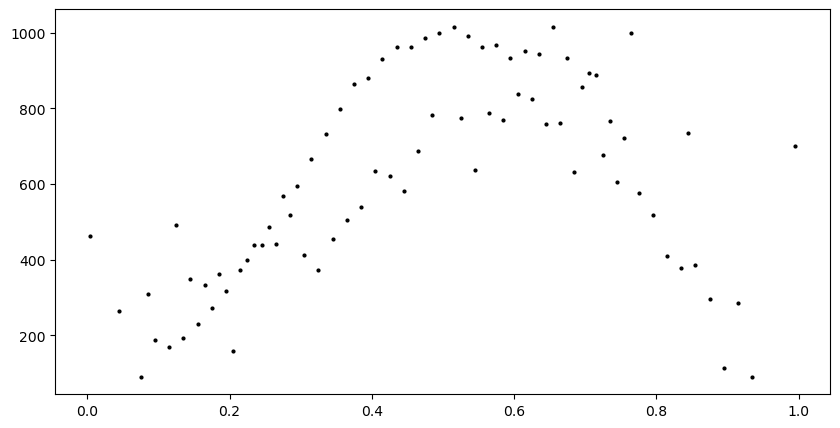

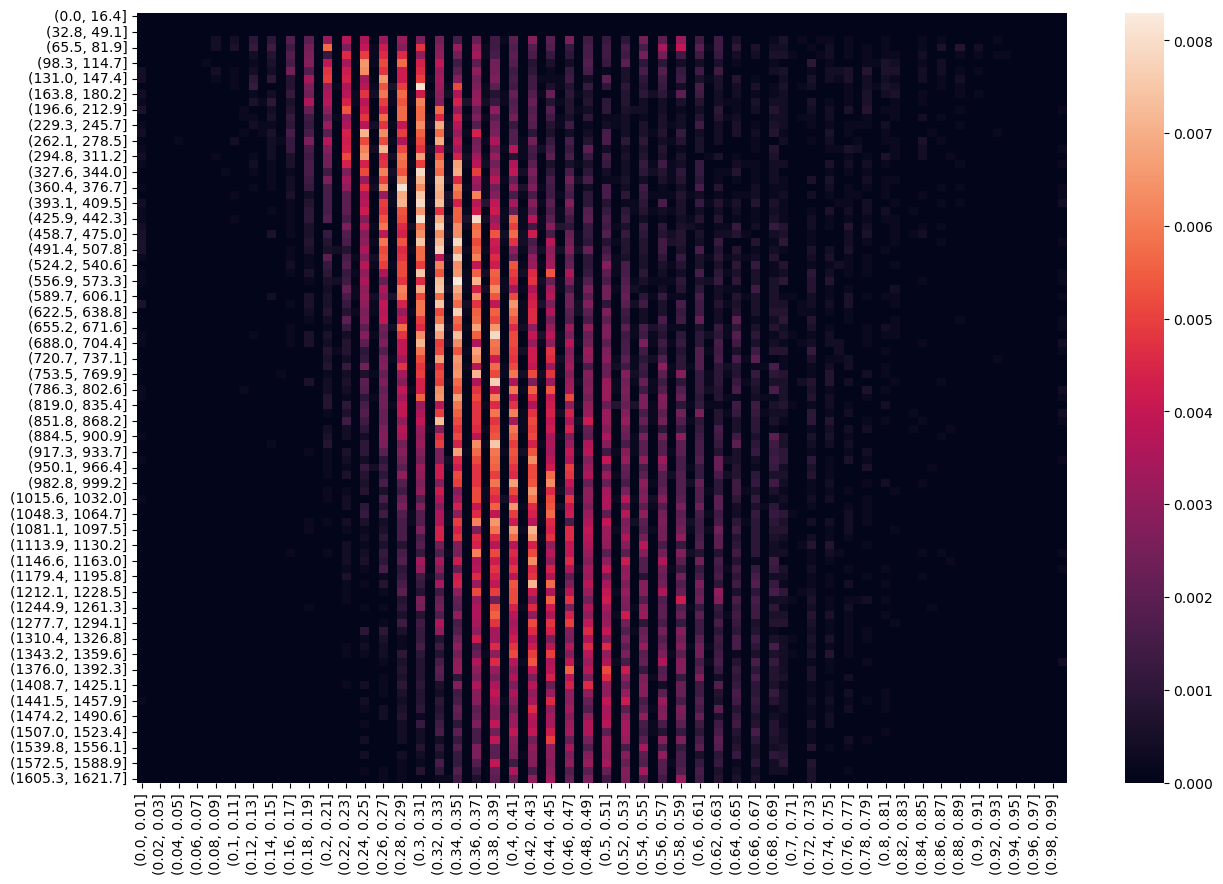

In [572]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(df_panelregionBin50_panelbam, trim_limits=(0.1, 0.1), histogram_mode='2d')

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


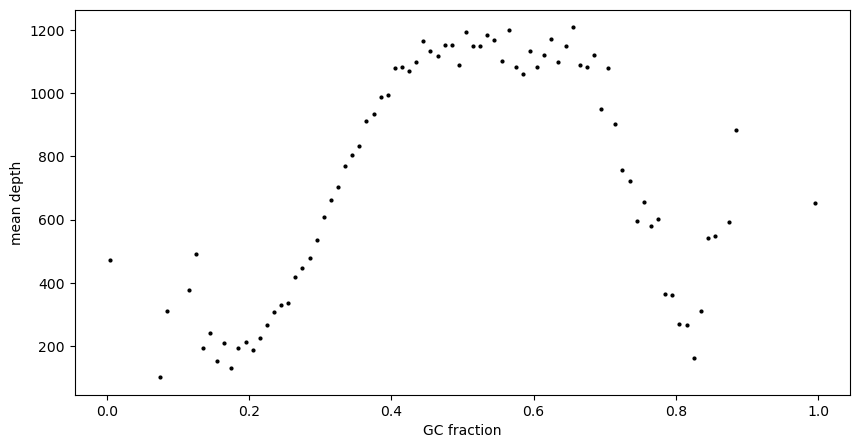

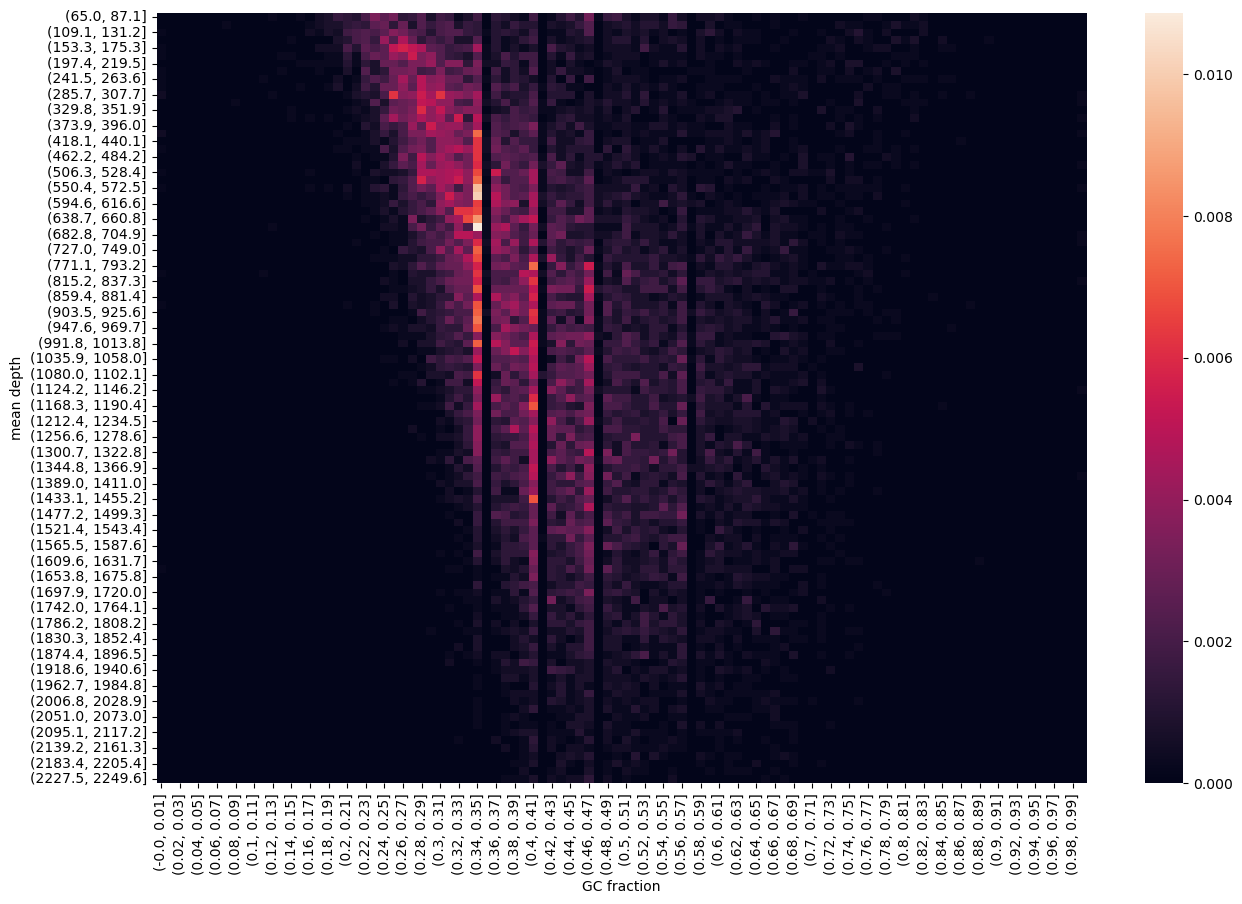

In [660]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_panelregionBin100_panelbam, trim_limits=(0.01, 0.01), lower_cutoff=50,
    scatter_ylims=None, heatmap_ylims=None, histogram_mode='2d',
    heatmap_vmax=None,
)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


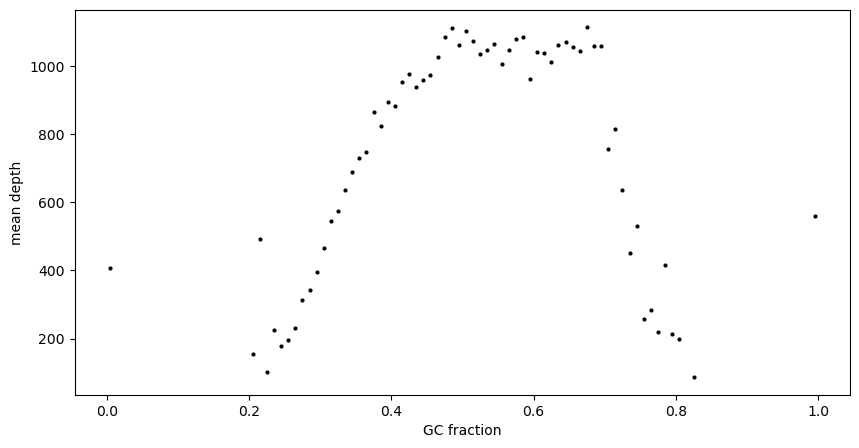

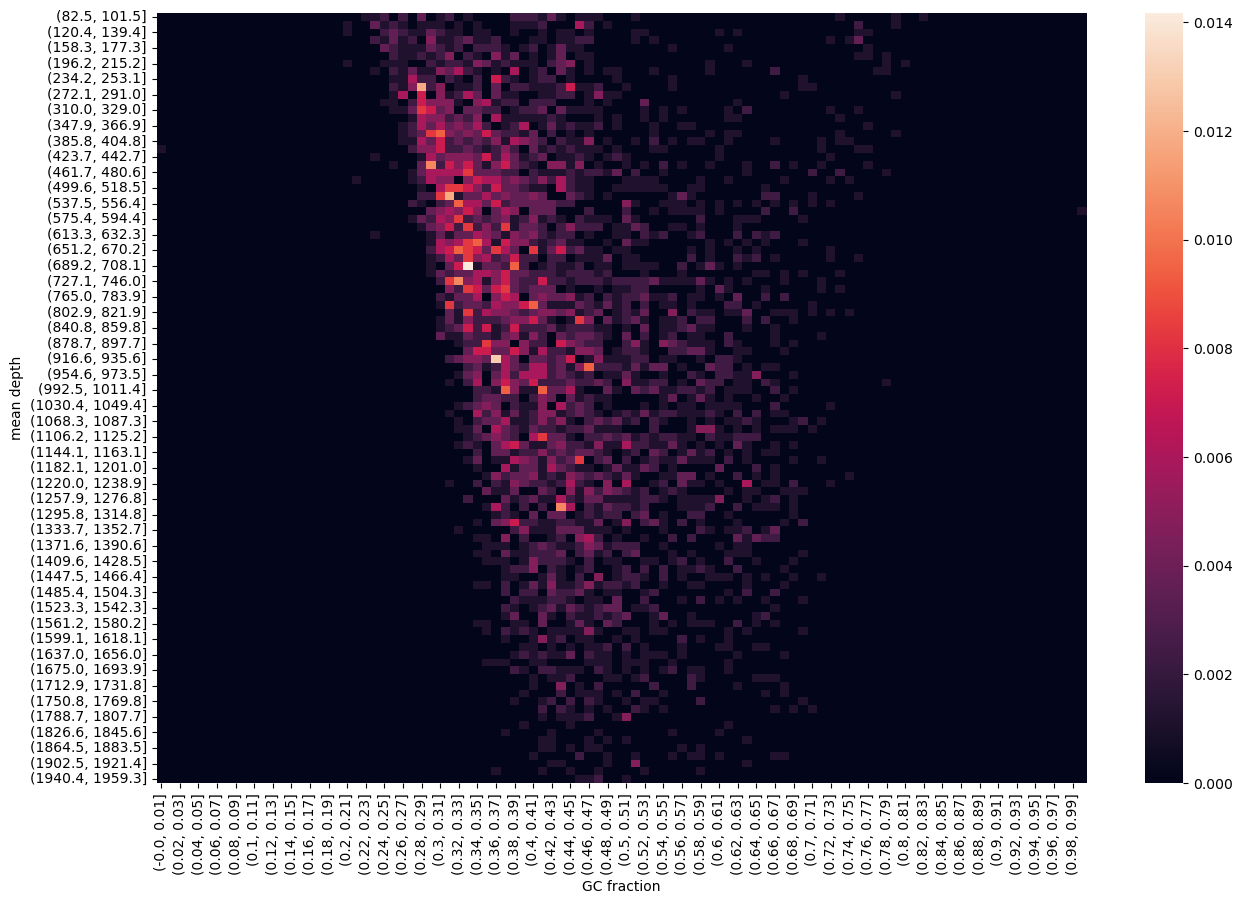

In [656]:
fig_avg_scatter, fig_heatmap = cnvmisc.plot_gc_distribution(
    df_panelregionBin500_panelbam, trim_limits=(0.01, 0.01), lower_cutoff=50,
    scatter_ylims=None, heatmap_ylims=None, histogram_mode='2d'
)

### Filtering and saving germline het SNVs - TPS

In [20]:
from handygenome.variant.filter import PonFilterPanelseqGermline#, TotaldepthFilter

pon_samples = [f'{x}_panel' for x in SAMPLEIDS_LU]
ponfilter = PonFilterPanelseqGermline(samples=pon_samples, check_global=True)
indir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/20_haplotypecaller_panelbamonly/results_with_readstats'
outdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/20_haplotypecaller_panelbamonly/filtered_germline_hets'

for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    
    sampleid_panel = f'{sampleid}_panel'

    panel_hc_vcf_path = os.path.join(indir, f'{sampleid}.HaplotypeCaller_panelbam.readstats.vcf.gz')
    panel_hc_vplist = VariantPlusList.from_vcf(panel_hc_vcf_path, init_all_attrs=True)

    def vpfilter(vp):
        readstats = vp.readstats_dict[sampleid_panel]
        sorted_vafs = vp.get_sorted_vafs(sampleid=sampleid_panel, exclude_other=True, reverse=True)
        return (
            len(vp.alts) == 1
            and ponfilter.check(vp, sampleid=sampleid_panel, allele_index=1)
            and readstats.get_total_rppcount(exclude_other=True) > 50
            and (
                readstats['rppcounts'][0] > 0
                and readstats['rppcounts'][1] > 0
                and readstats.get_vaf(alleleclass=-1, exclude_other=False) < 0.3
            )
            and all(len(x) == 1 for x in vp.alleles)
            and sorted_vafs[1] / sum(sorted_vafs) > 0.1
            # and readstats.get_vaf(alleleclass=-1, exclude_other=False) > 0.3
        )

    filtered_vplist = panel_hc_vplist.filter(vpfilter)    
    outfile_path = os.path.join(outdir, f'{sampleid}.filtered_panel_germline_snv.vcf.gz')
    filtered_vplist.write(outfile_path)

LU-14


[KST 2023-02-01 16:06:53.878] VariantPlusList: Processing 1,000th line


LU-6


[KST 2023-02-01 16:06:59.286] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:07:01.591] VariantPlusList: Processing 2,000th line


LU-87


[KST 2023-02-01 16:07:05.572] VariantPlusList: Processing 1,000th line


LU-F13


[KST 2023-02-01 16:07:11.176] VariantPlusList: Processing 1,000th line


LU-F2


[KST 2023-02-01 16:07:16.801] VariantPlusList: Processing 1,000th line


LU-F33


[KST 2023-02-01 16:07:26.453] VariantPlusList: Processing 1,000th line


LU-F37


[KST 2023-02-01 16:07:30.891] VariantPlusList: Processing 1,000th line


LU-FF1


[KST 2023-02-01 16:07:37.916] VariantPlusList: Processing 1,000th line


LU-FF104


[KST 2023-02-01 16:07:43.351] VariantPlusList: Processing 1,000th line


LU-FF115


[KST 2023-02-01 16:07:48.777] VariantPlusList: Processing 1,000th line


LU-FF13


[KST 2023-02-01 16:07:55.626] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:07:57.941] VariantPlusList: Processing 2,000th line


LU-FF18


[KST 2023-02-01 16:08:01.499] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:08:03.820] VariantPlusList: Processing 2,000th line


LU-FF20


[KST 2023-02-01 16:08:09.347] VariantPlusList: Processing 1,000th line


LU-FF21


[KST 2023-02-01 16:08:14.689] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:08:16.985] VariantPlusList: Processing 2,000th line


LU-FF23


[KST 2023-02-01 16:08:21.163] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:08:23.461] VariantPlusList: Processing 2,000th line


LU-FF24


[KST 2023-02-01 16:08:27.620] VariantPlusList: Processing 1,000th line


LU-FF27


[KST 2023-02-01 16:08:32.721] VariantPlusList: Processing 1,000th line


LU-FF3


[KST 2023-02-01 16:08:37.735] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:08:40.126] VariantPlusList: Processing 2,000th line


LU-FF31


[KST 2023-02-01 16:08:44.012] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:08:46.182] VariantPlusList: Processing 2,000th line


LU-FF34


[KST 2023-02-01 16:08:49.905] VariantPlusList: Processing 1,000th line


LU-FF37


[KST 2023-02-01 16:08:55.317] VariantPlusList: Processing 1,000th line


LU-FF39


[KST 2023-02-01 16:09:01.906] VariantPlusList: Processing 1,000th line


LU-FF4


[KST 2023-02-01 16:09:10.062] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:09:12.361] VariantPlusList: Processing 2,000th line


LU-FF43


[KST 2023-02-01 16:09:16.095] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:09:18.426] VariantPlusList: Processing 2,000th line


LU-FF53


[KST 2023-02-01 16:09:23.836] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:09:26.142] VariantPlusList: Processing 2,000th line


LU-FF56


[KST 2023-02-01 16:09:30.521] VariantPlusList: Processing 1,000th line


LU-FF57


[KST 2023-02-01 16:09:35.766] VariantPlusList: Processing 1,000th line


LU-FF58


[KST 2023-02-01 16:09:41.185] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:09:43.377] VariantPlusList: Processing 2,000th line


LU-FF6


[KST 2023-02-01 16:09:47.069] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:09:49.256] VariantPlusList: Processing 2,000th line


LU-FF62


[KST 2023-02-01 16:09:53.054] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:09:55.378] VariantPlusList: Processing 2,000th line


LU-FF67


[KST 2023-02-01 16:09:59.483] VariantPlusList: Processing 1,000th line


LU-FF71


[KST 2023-02-01 16:10:05.201] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:10:07.506] VariantPlusList: Processing 2,000th line


LU-FF76


[KST 2023-02-01 16:10:11.018] VariantPlusList: Processing 1,000th line


LU-FF77


[KST 2023-02-01 16:10:16.287] VariantPlusList: Processing 1,000th line


LU-FF78


[KST 2023-02-01 16:10:23.341] VariantPlusList: Processing 1,000th line


LU-FF79


[KST 2023-02-01 16:10:28.832] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:10:31.161] VariantPlusList: Processing 2,000th line


LU-FF80


[KST 2023-02-01 16:10:35.351] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:10:37.679] VariantPlusList: Processing 2,000th line


LU-FF85


[KST 2023-02-01 16:10:41.312] VariantPlusList: Processing 1,000th line


LU-IO05


[KST 2023-02-01 16:10:46.363] VariantPlusList: Processing 1,000th line


LU-IO06


[KST 2023-02-01 16:10:51.066] VariantPlusList: Processing 1,000th line


LU-IO07


[KST 2023-02-01 16:10:57.786] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:11:00.102] VariantPlusList: Processing 2,000th line


LU-IO08


[KST 2023-02-01 16:11:04.395] VariantPlusList: Processing 1,000th line


LU-IO09


[KST 2023-02-01 16:11:10.173] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:11:12.509] VariantPlusList: Processing 2,000th line


LU-IO12


[KST 2023-02-01 16:11:16.892] VariantPlusList: Processing 1,000th line


LU-IO13


[KST 2023-02-01 16:11:24.122] VariantPlusList: Processing 1,000th line


LU-IO15


[KST 2023-02-01 16:11:28.555] VariantPlusList: Processing 1,000th line


LU-IO16


[KST 2023-02-01 16:11:34.131] VariantPlusList: Processing 1,000th line


LU-IO17


[KST 2023-02-01 16:11:39.193] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:11:41.495] VariantPlusList: Processing 2,000th line


LU-IO18


[KST 2023-02-01 16:11:45.278] VariantPlusList: Processing 1,000th line


LU-IO22


[KST 2023-02-01 16:11:50.867] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:11:53.187] VariantPlusList: Processing 2,000th line


LU-IO23


[KST 2023-02-01 16:11:57.641] VariantPlusList: Processing 1,000th line


LU-IO24


[KST 2023-02-01 16:12:03.299] VariantPlusList: Processing 1,000th line


LU-IO25


[KST 2023-02-01 16:12:08.022] VariantPlusList: Processing 1,000th line


LU-SC126


[KST 2023-02-01 16:12:15.252] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:12:17.577] VariantPlusList: Processing 2,000th line


LU-SC134


[KST 2023-02-01 16:12:23.158] VariantPlusList: Processing 1,000th line


LU-SC31


[KST 2023-02-01 16:12:28.196] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:12:30.522] VariantPlusList: Processing 2,000th line


LU-SC81


[KST 2023-02-01 16:12:34.144] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:12:36.466] VariantPlusList: Processing 2,000th line


LU-SC88


[KST 2023-02-01 16:12:40.313] VariantPlusList: Processing 1,000th line


LU-SC97


[KST 2023-02-01 16:12:45.383] VariantPlusList: Processing 1,000th line


LU-SC98


[KST 2023-02-01 16:12:50.950] VariantPlusList: Processing 1,000th line
[KST 2023-02-01 16:12:53.274] VariantPlusList: Processing 2,000th line


### Filtering and saving germline het SNVs - WGS

In [87]:
vplist = VariantPlusList.from_vcf(
    '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/merged_vcfs/LU-14.merged.vcf.gz',
    init_all_attrs=False,
    logging_lineno=10000,
)

[E::idx_find_and_load] Could not retrieve index file for '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/merged_vcfs/LU-14.merged.vcf.gz'
[KST 2023-01-26 21:23:50.000] VariantPlusList: Processing 10,000th line
[KST 2023-01-26 21:23:50.351] VariantPlusList: Processing 20,000th line
[KST 2023-01-26 21:23:51.159] VariantPlusList: Processing 30,000th line
[KST 2023-01-26 21:23:51.883] VariantPlusList: Processing 40,000th line
[KST 2023-01-26 21:23:52.620] VariantPlusList: Processing 50,000th line
[KST 2023-01-26 21:23:52.971] VariantPlusList: Processing 60,000th line
[KST 2023-01-26 21:23:53.322] VariantPlusList: Processing 70,000th line
[KST 2023-01-26 21:23:54.103] VariantPlusList: Processing 80,000th line
[KST 2023-01-26 21:23:54.464] VariantPlusList: Processing 90,000th line
[KST 2023-01-26 21:23:54.812] VariantPlusList: Processing 100,000th line
[KST 2023-01-26 21:23:55.161] VariantPlusList: Processing 110,000th line
[KST 2023-01-26 21:23:56.327

In [44]:
from handygenome.variant.filter import PonFilterPanelseqGermline, PonFilterWGS
import handygenome.variant.ponbams as libponbams

pon_samples = libponbams.get_pon_sample_names(['SNULUNG', 'PCAWG', 'BGI'], 'hg19')
ponfilter = PonFilterWGS(samples=pon_samples, check_global=True)

indir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/annotation_230126'
outdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/20_haplotypecaller_panelbamonly/filtered_germline_hets'

for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    
    sampleid_panel = f'{sampleid}_panel'

    panel_hc_vcf_path = os.path.join(indir, f'{sampleid}.HaplotypeCaller_panelbam.readstats.vcf.gz')
    panel_hc_vplist = VariantPlusList.from_vcf(panel_hc_vcf_path, init_all_attrs=True)

    def vpfilter(vp):
        readstats = vp.readstats_dict[sampleid_panel]
        sorted_vafs = vp.get_sorted_vafs(sampleid=sampleid_panel, exclude_other=True, reverse=True)
        return (
            len(vp.alts) == 1
            and ponfilter.check(vp, sampleid=sampleid_panel, allele_index=1)
            and readstats.get_total_rppcount(exclude_other=True) > 50
            and (
                readstats['rppcounts'][0] > 0
                and readstats['rppcounts'][1] > 0
                and readstats.get_vaf(alleleclass=-1, exclude_other=False) < 0.3
            )
            and all(len(x) == 1 for x in vp.alleles)
            and sorted_vafs[1] / sum(sorted_vafs) > 0.1
            # and readstats.get_vaf(alleleclass=-1, exclude_other=False) > 0.3
        )

    filtered_vplist = panel_hc_vplist.filter(vpfilter)    
    outfile_path = os.path.join(outdir, f'{sampleid}.filtered_panel_germline_snv.vcf.gz')
    filtered_vplist.write(outfile_path)

LU-14


[KST 2023-01-16 17:18:47.099] VariantPlusList: Processing 1,000th line


LU-6


[KST 2023-01-16 17:18:52.508] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:18:54.887] VariantPlusList: Processing 2,000th line


LU-87


[KST 2023-01-16 17:18:58.811] VariantPlusList: Processing 1,000th line


LU-F13


[KST 2023-01-16 17:19:04.334] VariantPlusList: Processing 1,000th line


LU-F2


[KST 2023-01-16 17:19:10.330] VariantPlusList: Processing 1,000th line


LU-F33


[KST 2023-01-16 17:19:15.976] VariantPlusList: Processing 1,000th line


LU-F37


[KST 2023-01-16 17:19:20.337] VariantPlusList: Processing 1,000th line


LU-FF1


[KST 2023-01-16 17:19:26.045] VariantPlusList: Processing 1,000th line


LU-FF104


[KST 2023-01-16 17:19:31.473] VariantPlusList: Processing 1,000th line


LU-FF115


[KST 2023-01-16 17:19:37.062] VariantPlusList: Processing 1,000th line


LU-FF13


[KST 2023-01-16 17:19:42.599] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:19:45.029] VariantPlusList: Processing 2,000th line


LU-FF18


[KST 2023-01-16 17:19:48.501] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:19:50.724] VariantPlusList: Processing 2,000th line


LU-FF20


[KST 2023-01-16 17:19:55.138] VariantPlusList: Processing 1,000th line


LU-FF21


[KST 2023-01-16 17:19:59.238] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:20:01.599] VariantPlusList: Processing 2,000th line


LU-FF23


[KST 2023-01-16 17:20:05.149] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:20:07.507] VariantPlusList: Processing 2,000th line


LU-FF24


[KST 2023-01-16 17:20:11.659] VariantPlusList: Processing 1,000th line


LU-FF27


[KST 2023-01-16 17:20:16.674] VariantPlusList: Processing 1,000th line


LU-FF3


[KST 2023-01-16 17:20:23.488] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:20:25.881] VariantPlusList: Processing 2,000th line


LU-FF31


[KST 2023-01-16 17:20:29.632] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:20:31.874] VariantPlusList: Processing 2,000th line


LU-FF34


[KST 2023-01-16 17:20:35.714] VariantPlusList: Processing 1,000th line


LU-FF37


[KST 2023-01-16 17:20:41.243] VariantPlusList: Processing 1,000th line


LU-FF39


[KST 2023-01-16 17:20:46.613] VariantPlusList: Processing 1,000th line


LU-FF4


[KST 2023-01-16 17:20:52.279] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:20:54.677] VariantPlusList: Processing 2,000th line


LU-FF43


[KST 2023-01-16 17:20:58.301] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:21:00.712] VariantPlusList: Processing 2,000th line


LU-FF53


[KST 2023-01-16 17:21:04.600] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:21:06.936] VariantPlusList: Processing 2,000th line


LU-FF56


[KST 2023-01-16 17:21:11.168] VariantPlusList: Processing 1,000th line


LU-FF57


[KST 2023-01-16 17:21:16.000] VariantPlusList: Processing 1,000th line


LU-FF58


[KST 2023-01-16 17:21:23.770] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:21:26.245] VariantPlusList: Processing 2,000th line


LU-FF6


[KST 2023-01-16 17:21:29.898] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:21:32.288] VariantPlusList: Processing 2,000th line


LU-FF62


[KST 2023-01-16 17:21:36.313] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:21:38.516] VariantPlusList: Processing 2,000th line


LU-FF67


[KST 2023-01-16 17:21:42.621] VariantPlusList: Processing 1,000th line


LU-FF71


[KST 2023-01-16 17:21:49.881] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:21:52.094] VariantPlusList: Processing 2,000th line


LU-FF76


[KST 2023-01-16 17:21:56.120] VariantPlusList: Processing 1,000th line


LU-FF77


[KST 2023-01-16 17:22:01.255] VariantPlusList: Processing 1,000th line


LU-FF78


[KST 2023-01-16 17:22:07.035] VariantPlusList: Processing 1,000th line


LU-FF79


[KST 2023-01-16 17:22:12.515] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:22:14.872] VariantPlusList: Processing 2,000th line


LU-FF80


[KST 2023-01-16 17:22:19.162] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:22:21.518] VariantPlusList: Processing 2,000th line


LU-FF85


[KST 2023-01-16 17:22:24.974] VariantPlusList: Processing 1,000th line


LU-IO05


[KST 2023-01-16 17:22:29.938] VariantPlusList: Processing 1,000th line


LU-IO06


[KST 2023-01-16 17:22:34.836] VariantPlusList: Processing 1,000th line


LU-IO07


[KST 2023-01-16 17:22:40.348] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:22:42.773] VariantPlusList: Processing 2,000th line


LU-IO08


[KST 2023-01-16 17:22:47.162] VariantPlusList: Processing 1,000th line


LU-IO09


[KST 2023-01-16 17:22:53.063] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:22:55.476] VariantPlusList: Processing 2,000th line


LU-IO12


[KST 2023-01-16 17:22:58.929] VariantPlusList: Processing 1,000th line


LU-IO13


[KST 2023-01-16 17:23:04.766] VariantPlusList: Processing 1,000th line


LU-IO15


[KST 2023-01-16 17:23:10.112] VariantPlusList: Processing 1,000th line


LU-IO16


[KST 2023-01-16 17:23:16.065] VariantPlusList: Processing 1,000th line


LU-IO17


[KST 2023-01-16 17:23:23.332] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:23:25.792] VariantPlusList: Processing 2,000th line


LU-IO18


[KST 2023-01-16 17:23:29.724] VariantPlusList: Processing 1,000th line


LU-IO22


[KST 2023-01-16 17:23:35.266] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:23:37.639] VariantPlusList: Processing 2,000th line


LU-IO23


[KST 2023-01-16 17:23:41.740] VariantPlusList: Processing 1,000th line


LU-IO24


[KST 2023-01-16 17:23:47.301] VariantPlusList: Processing 1,000th line


LU-IO25


[KST 2023-01-16 17:23:52.364] VariantPlusList: Processing 1,000th line


LU-SC126


[KST 2023-01-16 17:23:58.103] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:24:00.544] VariantPlusList: Processing 2,000th line


LU-SC134


[KST 2023-01-16 17:24:05.124] VariantPlusList: Processing 1,000th line


LU-SC31


[KST 2023-01-16 17:24:10.326] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:24:12.676] VariantPlusList: Processing 2,000th line


LU-SC81


[KST 2023-01-16 17:24:16.631] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:24:19.043] VariantPlusList: Processing 2,000th line


LU-SC88


[KST 2023-01-16 17:24:24.224] VariantPlusList: Processing 1,000th line


LU-SC97


[KST 2023-01-16 17:24:29.408] VariantPlusList: Processing 1,000th line


LU-SC98


[KST 2023-01-16 17:24:35.129] VariantPlusList: Processing 1,000th line
[KST 2023-01-16 17:24:37.516] VariantPlusList: Processing 2,000th line


### Visualizing VAF proportions between alleles

<BarContainer object of 515 artists>

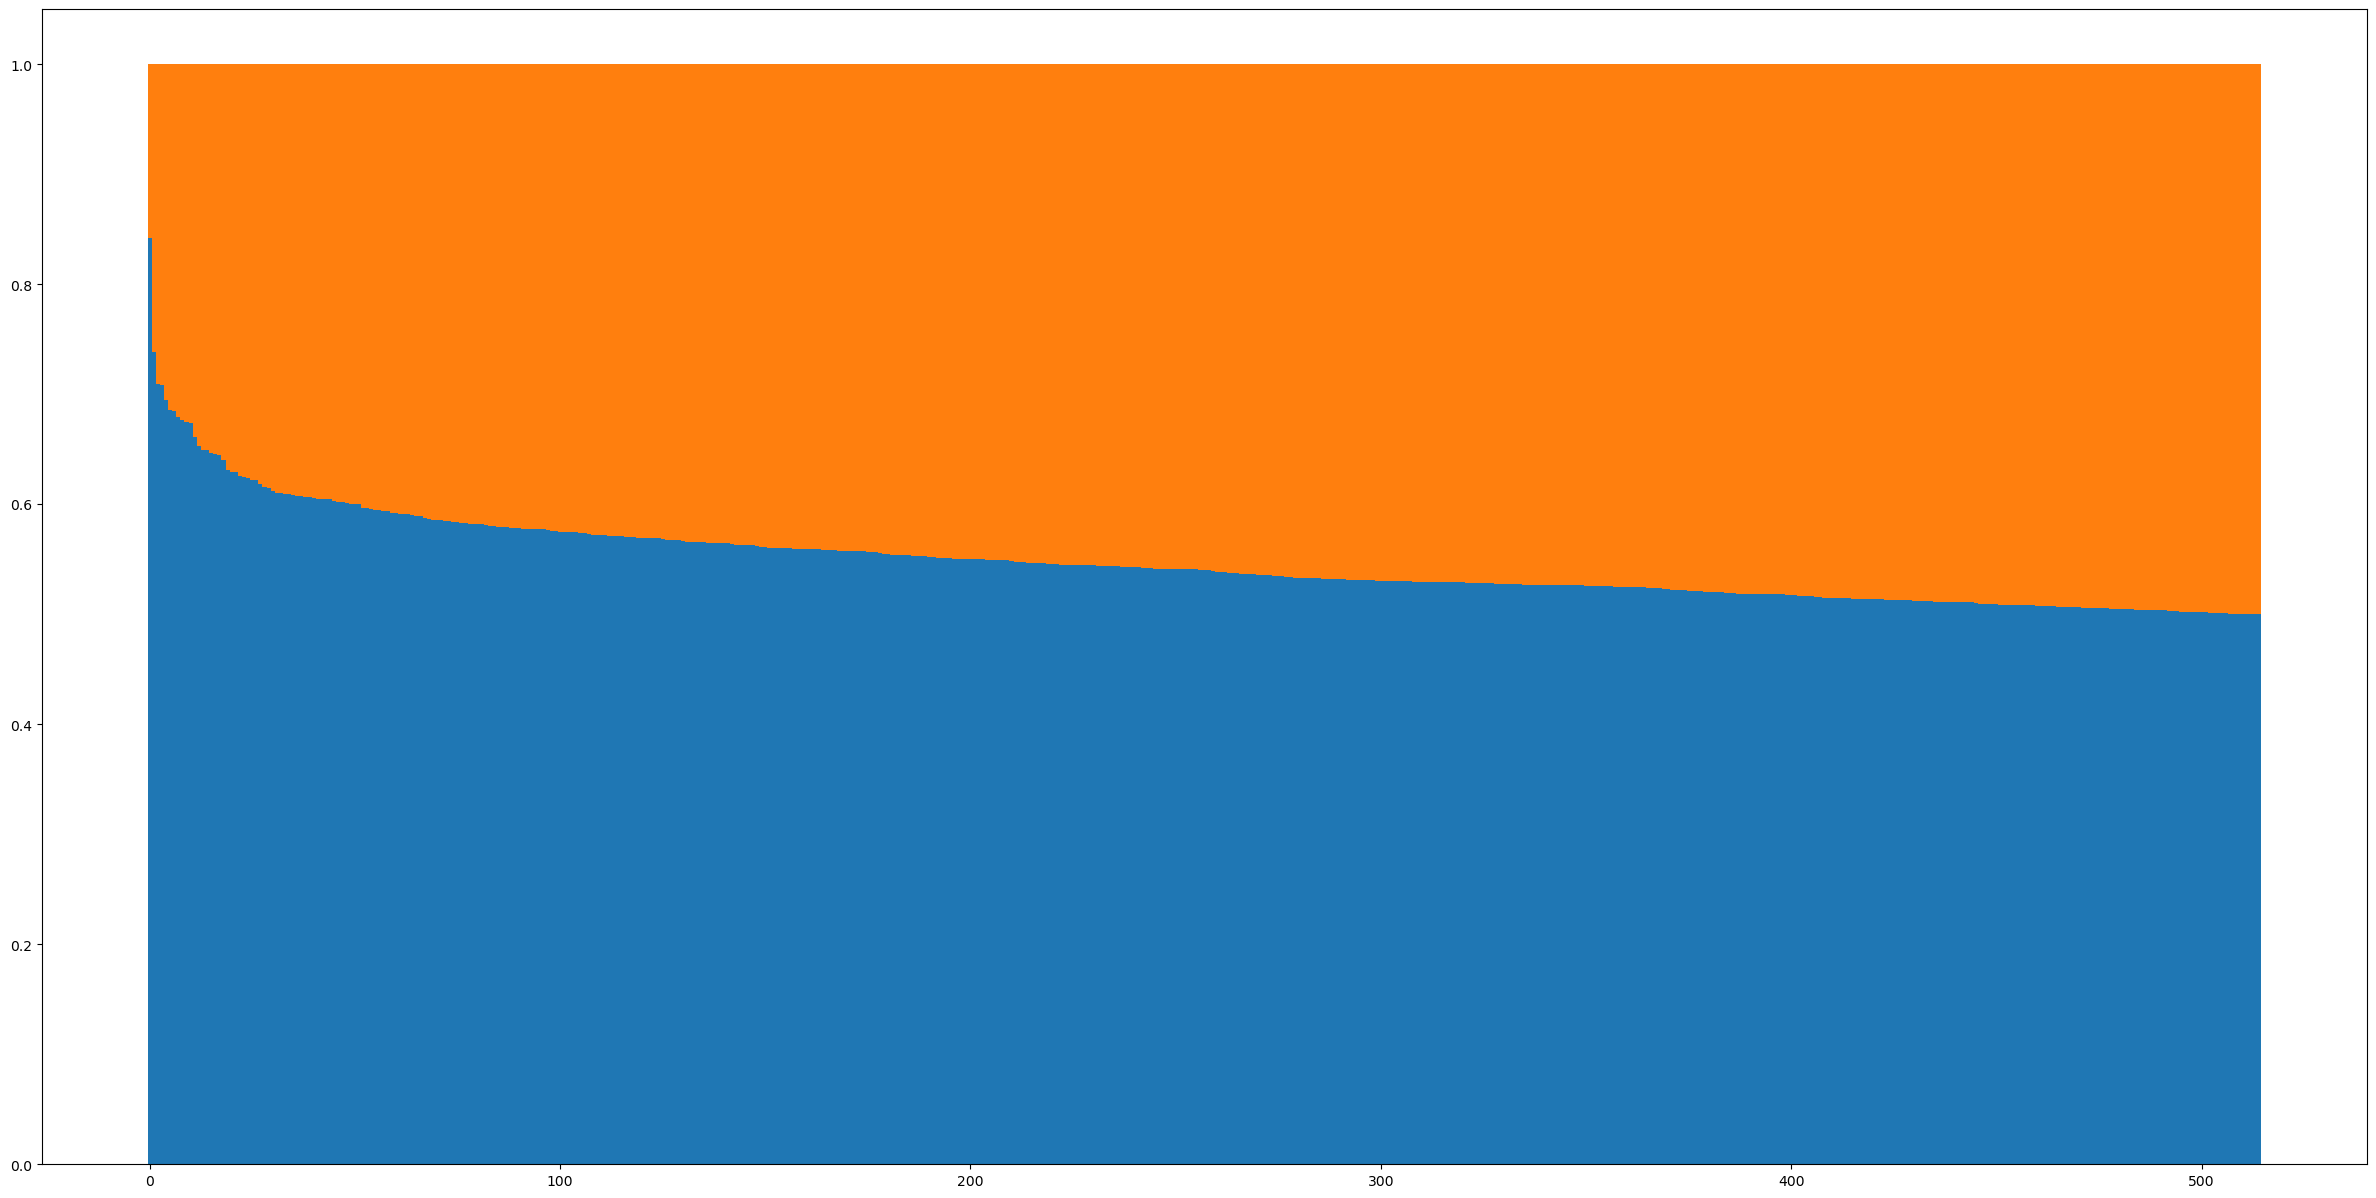

In [22]:
data = list()
for vp in filtered_vplist:
    sorted_vafs = vp.get_sorted_vafs(sampleid=sampleid_panel, exclude_other=True, reverse=True)
    data.append(sorted_vafs)
    # vafs = sorted(
    #     (
    #         vp.get_vaf(sampleid=f'{sampleid}_panel', allele_index=allele_index)
    #         for allele_index in range(len(vp.alts) + 1)
    #     ),
    #     reverse=True
    # )
    # vafs.extend([0] * (2 - len(vafs)))
    # data.append(vafs)

data.sort(reverse=True)
data = np.array(data)

x = list(range(len(data)))

cols = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

fig, ax = plt.subplots(figsize=(30, 15))

subset = len(x)
x_subset = x[:subset]
data_subset = data[:subset]

ax.bar(x_subset, data_subset[:, 0], color=cols[0], width=1)
ax.bar(x_subset, data_subset[:, 1], color=cols[1], width=1, bottom=data_subset[:, :1].sum(axis=1))
# ax.bar(x_subset, data_subset[:, 2], color=cols[2], width=1, bottom=data_subset[:, :2].sum(axis=1))

### PON plot

In [ ]:
from handygenome.variant.ponbams import PON_BAM_PATHS
SNULUNG_BAMS = {sampleid: pysam.AlignmentFile(bampath) for sampleid, bampath in PON_BAM_PATHS['hg19']['SNULUNG'].items()}

In [ ]:
pon_samples = [x + '_panel' for x in SAMPLEIDS_LU]

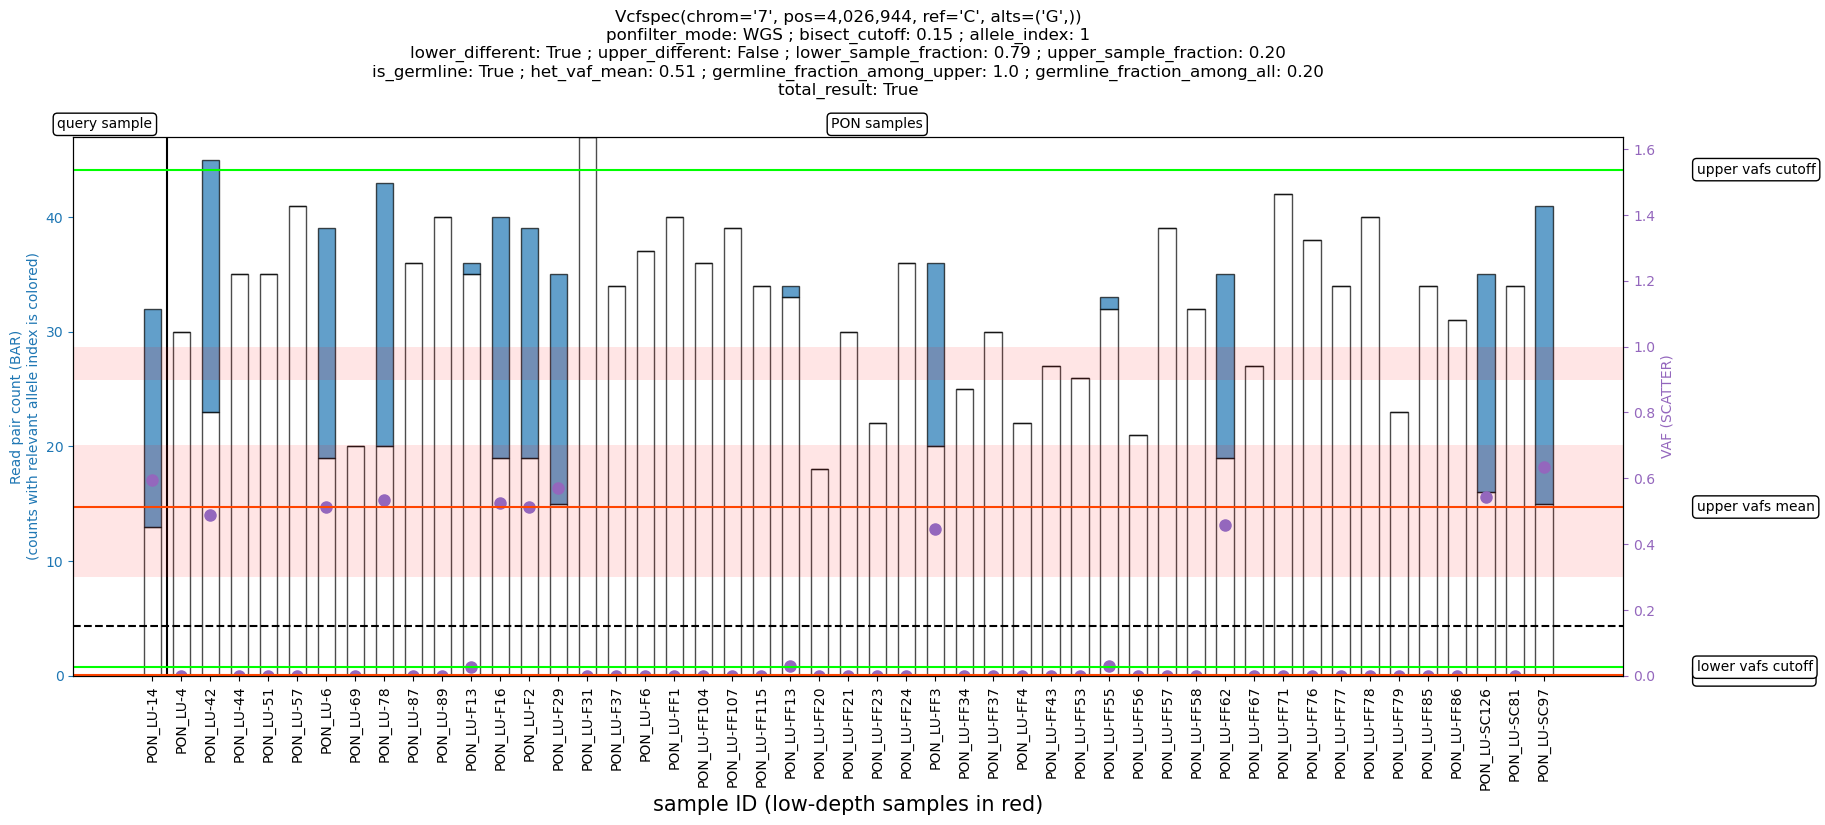

In [34]:
query_sample = f'{sampleid}_panel'

# vp.show_pon(query_sample=query_sample, allele_index=1, exclude_query=True, exclude_other=True, pon_samples=pon_samples, ponfilter_mode='PanelGermline')
vp.show_pon(query_sample='PON_LU-14', allele_index=1, exclude_query=True, exclude_other=True,  pon_cohorts=['SNULUNG'], ponfilter_mode='WGS')
# vp.show_pon(query_sample=query_sample, allele_index=1, exclude_query=True, pon_samples=pon_samples, ponfilter_mode='PanelSomatic')

In [32]:
vp.show_igv(igv, bam_dict, readheight='squish')

OK
OK
OK
OK
OK
OK
OK
OK
OK


In [33]:
vp.update_readstats(SNULUNG_BAMS)

### Main

##### set sampleid

In [21]:
sampleid = 'LU-14'
sampleid_panel = f'{sampleid}_panel'

In [22]:
t1 = time.perf_counter()

panelseq_depth_gr = get_postprocessed_panelregion_depth_gr(
    BAM_PATHS['panel'][sampleid], FASTA_HG19, PANEL_REGION_GR_FORDEPTH, mode='panel',
)
wgs_tumor_depth_gr = get_postprocessed_panelregion_depth_gr(
    BAM_PATHS['tumor'][sampleid], FASTA_HG19, PANEL_REGION_GR_FORDEPTH, mode='wgs',
)
wgs_normal_depth_gr = get_postprocessed_panelregion_depth_gr(
    BAM_PATHS['normal'][sampleid], FASTA_HG19, PANEL_REGION_GR_FORDEPTH, mode='wgs',
)

t2 = time.perf_counter()
print(t2 - t1)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


151.23855516780168


/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##### Load filtered germline hets

In [23]:
outdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/20_haplotypecaller_panelbamonly/filtered_germline_hets'

for fname in os.listdir(outdir):
    if fname.endswith('vcf.gz') and fname.startswith(sampleid):
        vcf_path = os.path.join(outdir, fname)
        
vplist = VariantPlusList.from_vcf(vcf_path, sampleid_list=[sampleid_panel])

In [24]:
gr_vaf = vplist.get_df(
    vaf_sampleid=sampleid_panel, 
    as_gr=True, 
    get_vaf_kwargs={'allele_index': 1, 'exclude_other': True}
)

In [153]:
plot_df.to_csv('/home/users/pjh/tmp/copynumber_df.tsv.gz', sep='\t', index=False)

##### Load WGS sequenza results - segments and extract

In [755]:
gr_wgs_segment = WGS_SEGMENT_GRS[sampleid]
gr_wgs_segment = gr_wgs_segment[gr_wgs_segment.Chromosome.isin(PANEL_REGION_GR_FORDEPTH.Chromosome)]

gr_wgs_extract = sequenza_handler.load_extract(WGS_EXTRACT_PATHS[sampleid], CHROMDICT_HG19, as_gr=True)
gr_wgs_extract = gr_wgs_extract[gr_wgs_extract.Chromosome.isin(PANEL_REGION_GR_FORDEPTH.Chromosome)]

##### Load cnvkit results

In [839]:
cnvkit_segment_gr, cnvkit_cnr_gr, cnvkit_call_gr = prepare_cnvkit_grs(CNVKIT_SEGMENT_PATHS[sampleid], CNVKIT_CNR_PATHS[sampleid], CNVKIT_SEGMENT_CALL_PATHS[sampleid])

##### Plotting

In [44]:
plot_df = pd.DataFrame.from_dict({
    'Chromosome': panelseq_depth_gr.Chromosome,
    'Start': panelseq_depth_gr.Start,
    'End': panelseq_depth_gr.End,
    'GC': panelseq_depth_gr.GC,    
})

plot_df = plot_df.assign(**{
    f'panel_tumor_{key}': val for key, val in panelseq_depth_gr.df.items()
    if key.endswith('mean_depth')
})
plot_df = plot_df.assign(**{
    f'panel_normal_{key}': val for key, val in merged_blood_panelseq_gr.df.items()
    if key.endswith('mean_depth')
})

plot_df = plot_df.assign(**{
    f'wgs_tumor_{key}': val for key, val in wgs_tumor_depth_gr.df.items()
    if key.endswith('mean_depth')
})
plot_df = plot_df.assign(**{
    f'wgs_normal_{key}': val for key, val in wgs_normal_depth_gr.df.items()
    if key.endswith('mean_depth')
})

plot_df.insert(
    plot_df.shape[1],
    'panel_depthratio_sequenzastyle',
    plot_df['panel_tumor_sequenza_style_norm_mean_depth'] / plot_df['panel_normal_sequenza_style_norm_mean_depth']
)
plot_df.insert(
    plot_df.shape[1],
    'panel_depthratio_mystyle',
    plot_df['panel_tumor_norm_mean_depth'] / plot_df['panel_normal_norm_mean_depth']
)
plot_df.insert(
    plot_df.shape[1],
    'wgs_depthratio_sequenzastyle',
    plot_df['wgs_tumor_sequenza_style_norm_mean_depth'] / plot_df['wgs_normal_sequenza_style_norm_mean_depth']
)
plot_df.insert(
    plot_df.shape[1],
    'wgs_depthratio_mystyle',
    plot_df['wgs_tumor_norm_mean_depth'] / plot_df['wgs_normal_norm_mean_depth']
)

In [924]:
plot_gr = pr.PyRanges(plot_df, int64=True)

plot_gr = pyranges_helper.join(
    plot_gr,
    pr.PyRanges(
        cnvkit_call_gr[['cn', 'p_ttest']].df.rename(
            columns={'cn': 'cnvkit_cn', 'p_ttest': 'cnvkit_p_ttest'}
        ), 
        int64=True
    ),
    how='left',
    merge='mean',
)
plot_gr = pyranges_helper.join(
    plot_gr,
    cnvkit_cnr_gr[['cnr_depthratio']],
    how='left',
    merge='mean',
)
plot_gr = pyranges_helper.join(
    plot_gr,
    pr.PyRanges(
        gr_wgs_segment[['CNt', 'A', 'B']].df.rename(
            columns={
                'CNt': 'wgs_CNt', 
                'A': 'wgs_A', 
                'B': 'wgs_B',
            }
        ), 
        int64=True,
    ),
    how='left',
    merge='mean',
)
plot_gr = pyranges_helper.join(
    plot_gr,
    pr.PyRanges(PANEL_REGION_WITHGENE_GR.df.rename(columns={'Name': 'gene'}), int64=True),
    how='left',
    merge='first',
)

In [1235]:
PANEL_REGION_GR_FORDEPTH

+--------------+-----------+-----------+
| Chromosome   | Start     | End       |
| (category)   | (int32)   | (int32)   |
|--------------+-----------+-----------|
| 1            | 1570592   | 1570692   |
| 1            | 1570692   | 1570792   |
| 1            | 1570792   | 1570892   |
| 1            | 1570892   | 1570992   |
| ...          | ...       | ...       |
| X            | 47431011  | 47431111  |
| X            | 47431111  | 47431211  |
| X            | 47431211  | 47431311  |
| X            | 47431311  | 47431330  |
+--------------+-----------+-----------+
Unstranded PyRanges object has 19,700 rows and 3 columns from 21 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

In [1236]:
import handygenome.cnv.plot as cnvplot

region_gr = PANEL_REGION_GR_FORDEPTH.copy()
region_gr.weight = 1
converter = cnvplot.CoordConverter(region_gr)

In [1237]:
converter.genomic_to_plot('5', 1282733)

657661.0

In [1238]:
converter.plot_to_genomic(1890255)

('X', 47431313)

In [1223]:
import handygenome.cnv.plot as cnvplot

In [1224]:
region_gr = PANEL_REGION_GR_FORDEPTH.copy()
region_gr.weight = 1
converter = cnvplot.CoordConverter(region_gr)
converter2 = cnvplot.CoordConverter2(region_gr)

In [1233]:
%%timeit
converter.genomic_to_plot('5', 1282733)

656 µs ± 5.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1234]:
%%timeit
converter2.genomic_to_plot('5', 1282733)

1.74 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1209]:
%%timeit
converter.genomic_to_plot('1', 1570592)

791 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1210]:
%%timeit
converter.genomic_to_plot2('1', 1570592)

707 µs ± 6.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1174]:
converter.plot_to_genomic(1890255)

('X', 47431313)

In [1200]:
df = pd.DataFrame(
    {'a': [1, 2], 'b': [3, 4], 'c': [5, 6]}, 
    index=pd.MultiIndex.from_arrays([['A', 'B'], ['X', 'Y']]),
)

In [1211]:
intvidx = pd.IntervalIndex.from_breaks([0, 1, 2, 3])

[autoreload of handygenome.cnv.plot failed: Traceback (most recent call last):
  File "/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  

In [1222]:
intvidx[]

IntervalIndex([(1, 2], (2, 3]], dtype='interval[int64, right]')

In [1218]:
intvidx

IntervalIndex([(0, 1], (1, 2], (2, 3]], dtype='interval[int64, right]')

In [2231]:
gr_for_plot.x_for_plot = list(gr_for_plot.df.iloc[:, :2].apply(
    lambda x: convert_coord(x[0], x[1], coord_converters), 
    axis=1,
))

gr_vaf.x_for_plot = list(gr_vaf.df.iloc[:, :2].apply(
    lambda x: convert_coord(x[0], x[1], coord_converters), 
    axis=1,
))

# gr_wgs_segment.x_for_plot = list(gr_wgs_segment.df.iloc[:, :2].apply(
#     lambda x: convert_coord(x[0], x[1], coord_converters), 
#     axis=1,
# ))


In [2232]:
# subdf_list = list()

gene_locations = dict()

for key, subdf in gr_for_plot.df.loc[
    (gr_for_plot.df['wgs_CNt'] > 2) | (gr_for_plot.df['cnvkit_cn'] > 2), 
    :
].groupby('gene'):
    if subdf.shape[0] > 500:
        # subdf_list.append(subdf.iloc[:1, :])
        # subdf_list.append(subdf.iloc[int(subdf.shape[0] * 0.5), :])
        gene_locations[key] = (subdf.iloc[0, :]['x_for_plot'], subdf.iloc[-1, :]['x_for_plot'])
        
# gr_gene = pr.PyRanges(pd.concat(subdf_list), int64=True)
# df_gene = pd.DataFrame.from_records(subdf_list)

In [2233]:
chrom_borders = dict()
chrom_midpoints = dict()
for chrom, subgr in gr_for_plot.items():
    chrom_borders[chrom] = subgr.iloc[-1, :]['x_for_plot']
    chrom_midpoints[chrom] = (subgr.iloc[[0, -1], :]['x_for_plot'].mean())

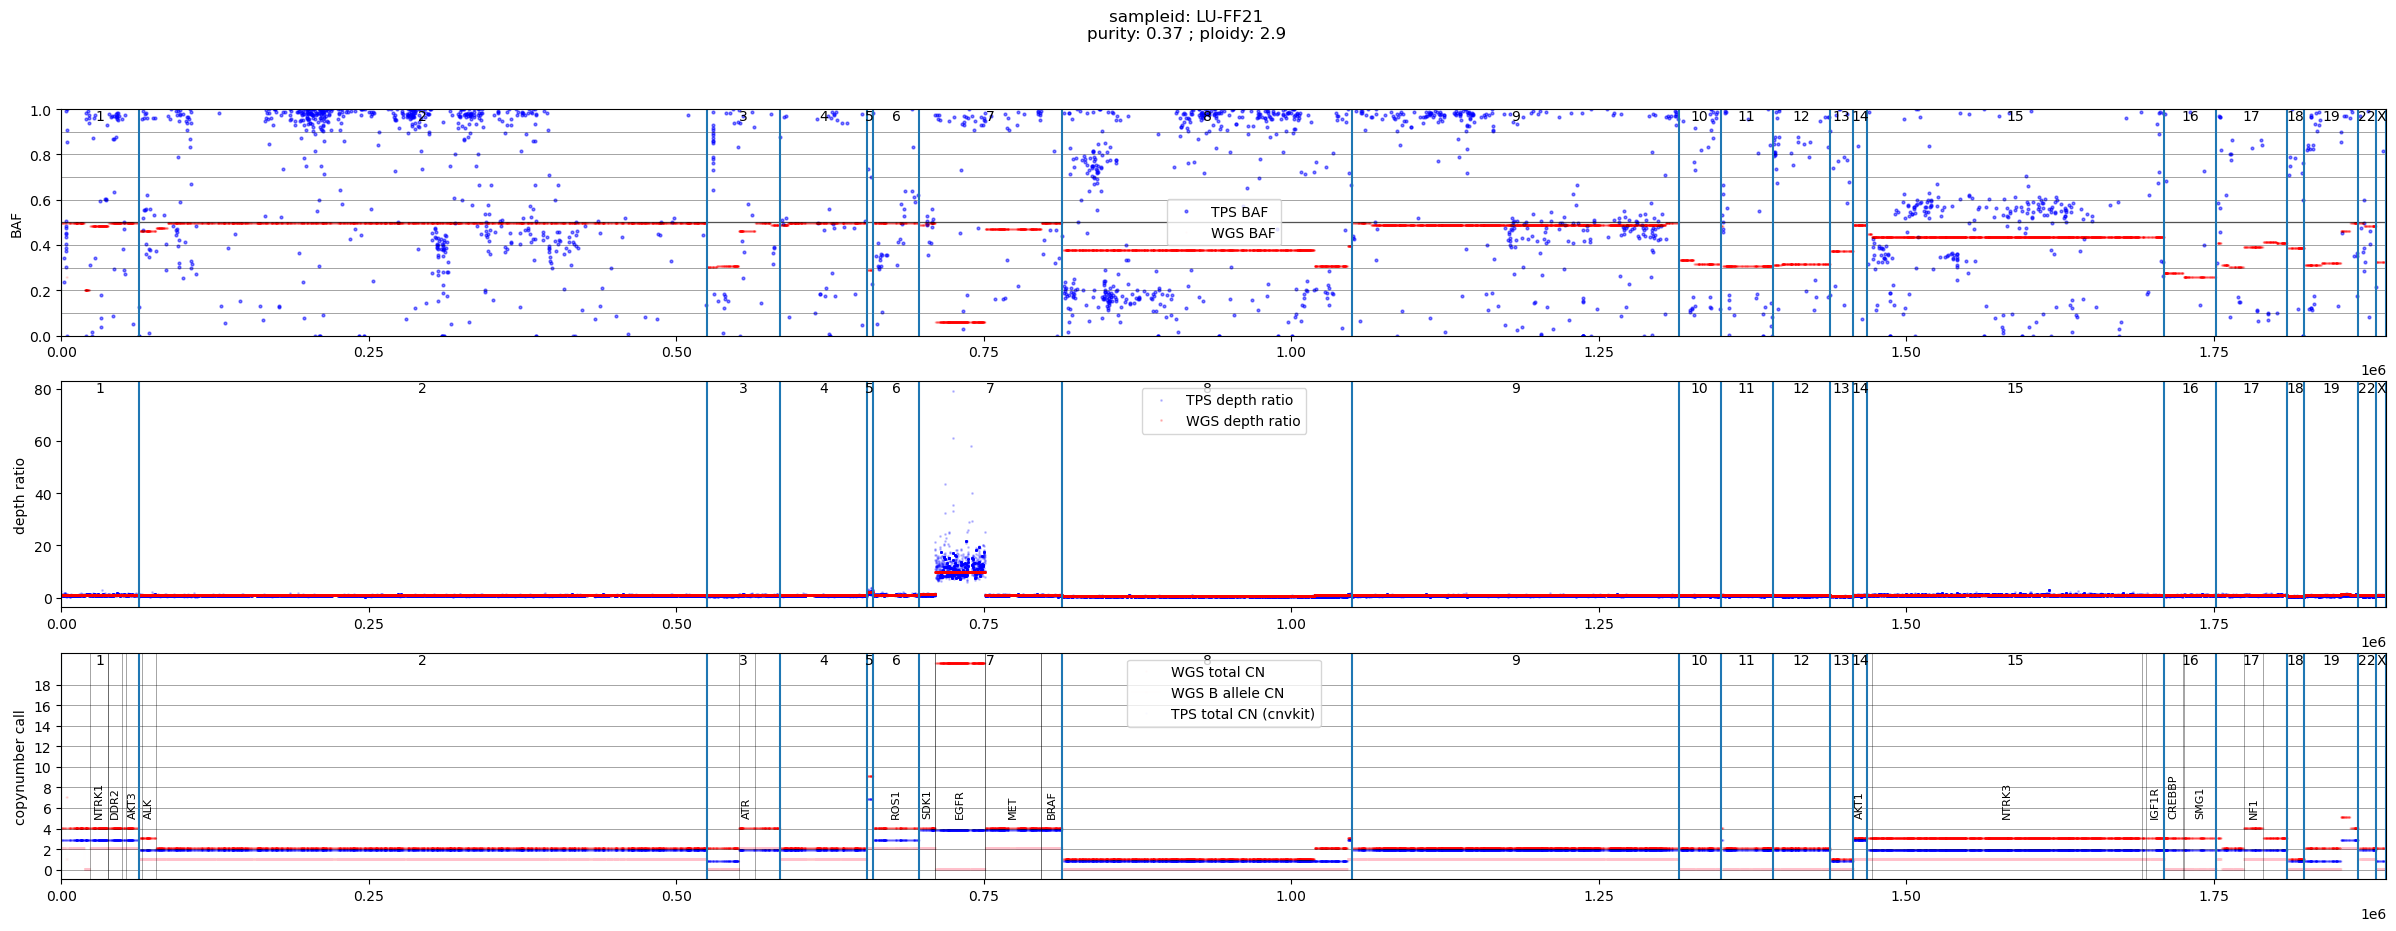

In [2239]:
fig, axs = plt.subplots(3, 1, figsize=(30, 10))

fig.suptitle(f'sampleid: {sampleid}\npurity: {PREVIOUS_PURITY[sampleid]} ; ploidy: {PREVIOUS_PLOIDY[sampleid]}')

ax_baf = axs[0]
ax_depthratio = axs[1]
ax_cn = axs[2]


# ax_depthratio
ax_depthratio.plot(gr_for_plot.df['x_for_plot'], gr_for_plot.df['depth_ratio_sequenzastyle'], 'bo', alpha=0.2, markersize=1, label='TPS depth ratio')
ax_depthratio.plot(gr_for_plot.df['x_for_plot'], gr_for_plot.df['wgs_depthratio'], 'ro', alpha=0.2, markersize=1, label='WGS depth ratio')

ax_depthratio.set_ylabel('depth ratio')
ax_depthratio.legend()
# ax_cn.set_ylabel('TPS CN call')

# ax_baf
ax_baf.set_ylim(0, 1)
ax_baf.plot(gr_vaf.df['x_for_plot'], gr_vaf.df['VAF'], 'bo', alpha=0.5, markersize=2, label='TPS BAF')
ax_baf.plot(gr_for_plot.df['x_for_plot'], gr_for_plot.df['wgs_BAF'], 'ro', alpha=0.01, markersize=1, label='WGS BAF')

for y in np.arange(0, 1, 0.1):
    ax_baf.axhline(y, alpha=0.5, color='black', linewidth=0.5)
ax_baf.axhline(0.5, alpha=0.5, color='black', linewidth=1)
    
ax_baf.set_ylabel('BAF')
ax_baf.legend()

# ax_cn
ax_cn.plot(gr_for_plot.df['x_for_plot'], gr_for_plot.df['wgs_CNt'] + 0.1, 'ro', alpha=0.01, markersize=1, label='WGS total CN')
ax_cn.plot(gr_for_plot.df['x_for_plot'], gr_for_plot.df['wgs_B'] + 0.1, marker='o', color='pink', alpha=0.01, markersize=1, label='WGS B allele CN')
ax_cn.plot(gr_for_plot.df['x_for_plot'], gr_for_plot.df['cnvkit_cn'] - 0.1, 'bo', alpha=0.01, markersize=1, label='TPS total CN (cnvkit)')

for genename, (start, end) in gene_locations.items():
    ax_cn.annotate(genename, ((start + end) / 2, 5), rotation=90, ha='center', va='bottom', size=8)
    ax_cn.axvline(start, color='black', linewidth=0.5, alpha=0.5)
    ax_cn.axvline(end, color='black', linewidth=0.5, alpha=0.5)
    
ax_cn.set_ylabel('copynumber call')
ymax = max(gr_for_plot.df['cnvkit_cn'].max(), gr_for_plot.df['wgs_CNt'].max())
ax_cn.set_yticks(np.arange(0, ymax, 2).astype('int'))
for y in np.arange(0, ymax, 2).astype('int'):
    ax_cn.axhline(y, alpha=0.5, color='black', linewidth=0.5)
ax_cn.legend()

# common
for ax in axs:
    ax.set_xlim(0, coord_converters['X'].iloc[-1])
    for x in [0] + list(chrom_borders.values()):
        ax.axvline(x)
    for chrom, x in chrom_midpoints.items():
        ax.annotate(chrom, (x, ax.get_ylim()[1]), ha='center', va='top', size=10)


_ = ax_baf.set_ylabel('BAF')

In [1762]:
gr_for_write = processed_depth_gr.copy()
gr_for_write.depth_ratio_sequenzastyle = list(depth_ratio_sequenzastyle)
gr_for_write.depth_ratio_mystyle = list(depth_ratio_mystyle)

outfile_path = '/home/users/pjh/practice/r-copynumber/data.bed.gz'
gr_for_write.df.to_csv(outfile_path, sep='\t', index=False)

In [1766]:
processed_depth_gr

+--------------+-----------+-----------+--------------+-------+
| Chromosome   | Start     | End       | mean_depth   | +4    |
| (category)   | (int64)   | (int64)   | (float64)    | ...   |
|--------------+-----------+-----------+--------------+-------|
| 1            | 1570592   | 1570642   | 68.6         | ...   |
| 1            | 1570642   | 1570692   | 106.48       | ...   |
| 1            | 1570692   | 1570742   | 315.0        | ...   |
| 1            | 1570742   | 1570792   | 653.1        | ...   |
| ...          | ...       | ...       | ...          | ...   |
| X            | 47431161  | 47431211  | 653.78       | ...   |
| X            | 47431211  | 47431261  | 612.38       | ...   |
| X            | 47431261  | 47431311  | 608.88       | ...   |
| X            | 47431311  | 47431330  | 522.63       | ...   |
+--------------+-----------+-----------+--------------+-------+
Unstranded PyRanges object has 38,608 rows and 8 columns from 21 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
4 hidden columns: GC, norm_mean_depth, gc_corrected_mean_depth, sequenza_style_norm_mean_depth

In [1371]:
gr = next(iter(blood_panelseq_depth_grs.values()))
merged_blood_depth_df = pd.DataFrame.from_dict({
    'Chromosome': gr.Chromosome,
    'Start': gr.Start,
    'End': gr.End,
})

for sid, gr in blood_panelseq_depth_grs.items():
    mean = gr.Mean
    norm_mean = mean / gr.Mean.mean()
    merged_blood_depth_df.insert(
        merged_blood_depth_df.shape[1],
        f'{sid}_mean',
        gr.Mean,
    )
    merged_blood_depth_df.insert(
        merged_blood_depth_df.shape[1],
        f'{sid}_norm_mean',
        norm_mean,
    )
    
merged_blood_depth_df.insert(
    merged_blood_depth_df.shape[1], 
    'merged_mean',
    merged_blood_depth_df.loc[:, [x for x in merged_blood_depth_df.columns if (x.endswith('_mean') and (not x.endswith('_norm_mean')))]].apply(np.mean, axis=1),
)
merged_blood_depth_df.insert(
    merged_blood_depth_df.shape[1], 
    'merged_norm_mean',
    merged_blood_depth_df.loc[:, [x for x in merged_blood_depth_df.columns if x.endswith('norm_mean')]].apply(np.mean, axis=1),
)

In [1373]:
from handygenome.cnv.misc import add_gc_to_df

add_gc_to_df(merged_blood_depth_df, FASTA_HG19)

### Calculate outlier cutoff for each GC bin

In [1375]:
cutresult = pd.cut(merged_blood_depth_df.GC, bins=100)
norm_mean_df = merged_blood_depth_df.loc[:, [x for x in merged_blood_depth_df.columns if x.endswith('norm_mean')]]
cutoffs = dict()
for intv, data in norm_mean_df.groupby(cutresult):
    arr = data.to_numpy().ravel()
    if len(arr) == 0:
        cutoff_val = np.nan
    else:
        cutoff_val = np.mean(arr) + 4 * np.std(arr)
    cutoffs[intv] = cutoff_val

### Plot GC-depth relationship with outlier cutoff

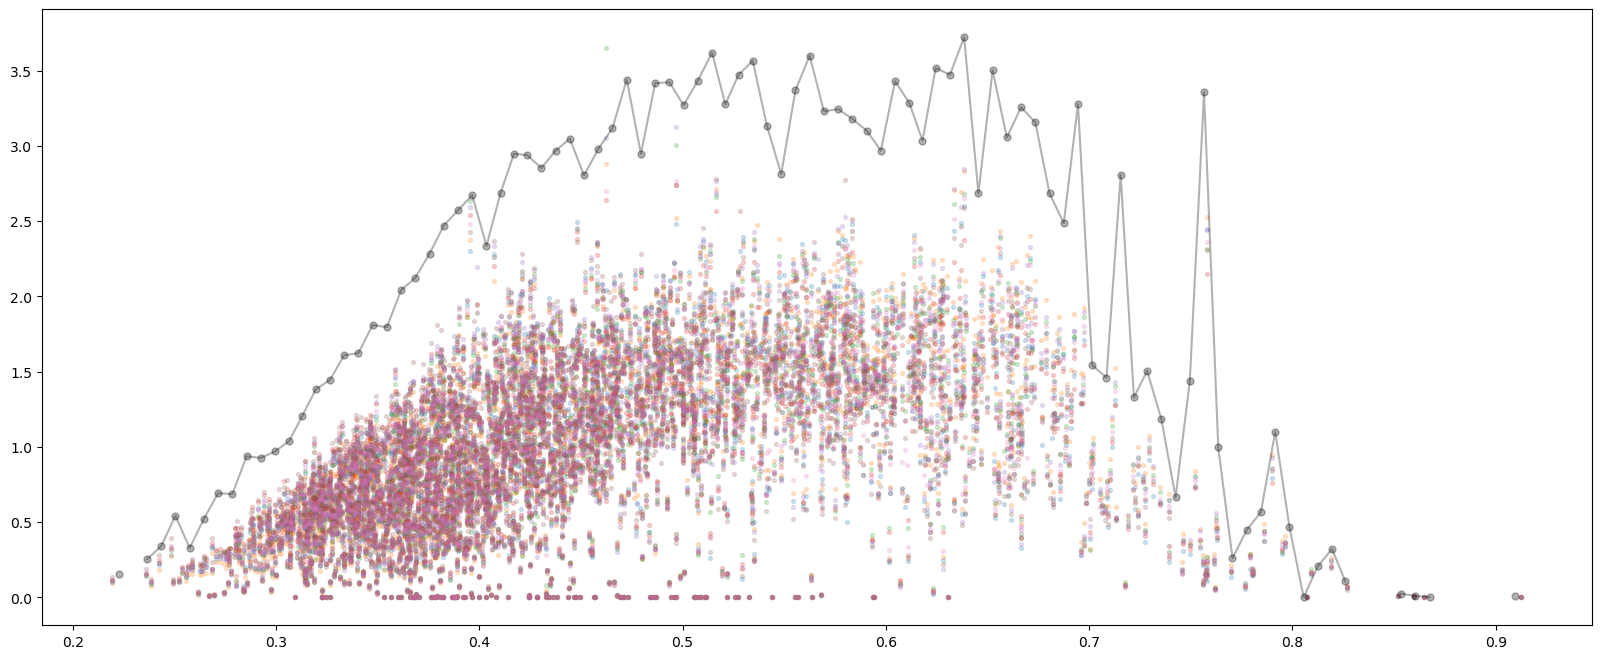

In [1376]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_prop_cycle(plt.rcParams['axes.prop_cycle'])
for colname, column in norm_mean_df.items():
    ax.scatter(merged_blood_depth_df.GC, column, s=8, alpha=0.2)

x = list()
y = list()
for intv, val in cutoffs.items():
    x.append(intv.mid)
    y.append(val)
ax.plot(x, y, 'ko-', markersize=5, alpha=0.3)

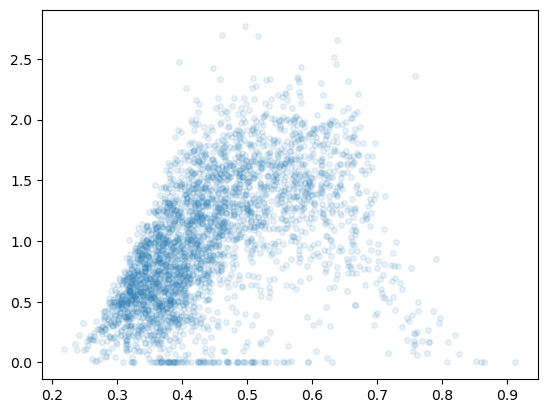

In [1233]:
plt.plot(merged_blood_depth_df.GC, merged_blood_depth_df.merged_norm_mean, linestyle='', marker='o', markersize=4, alpha=0.1)

### Plot inter-sample normalized-depth variance

In [1234]:
# sort by width
means_df = merged_blood_depth_df.loc[:, [x for x in merged_blood_depth_df.columns if x.endswith('norm_mean')]]
width = means_df.apply(lambda x: x.max() - x.min(), axis=1)
sorted_df = merged_blood_depth_df.iloc[np.argsort(width)[::-1], :]

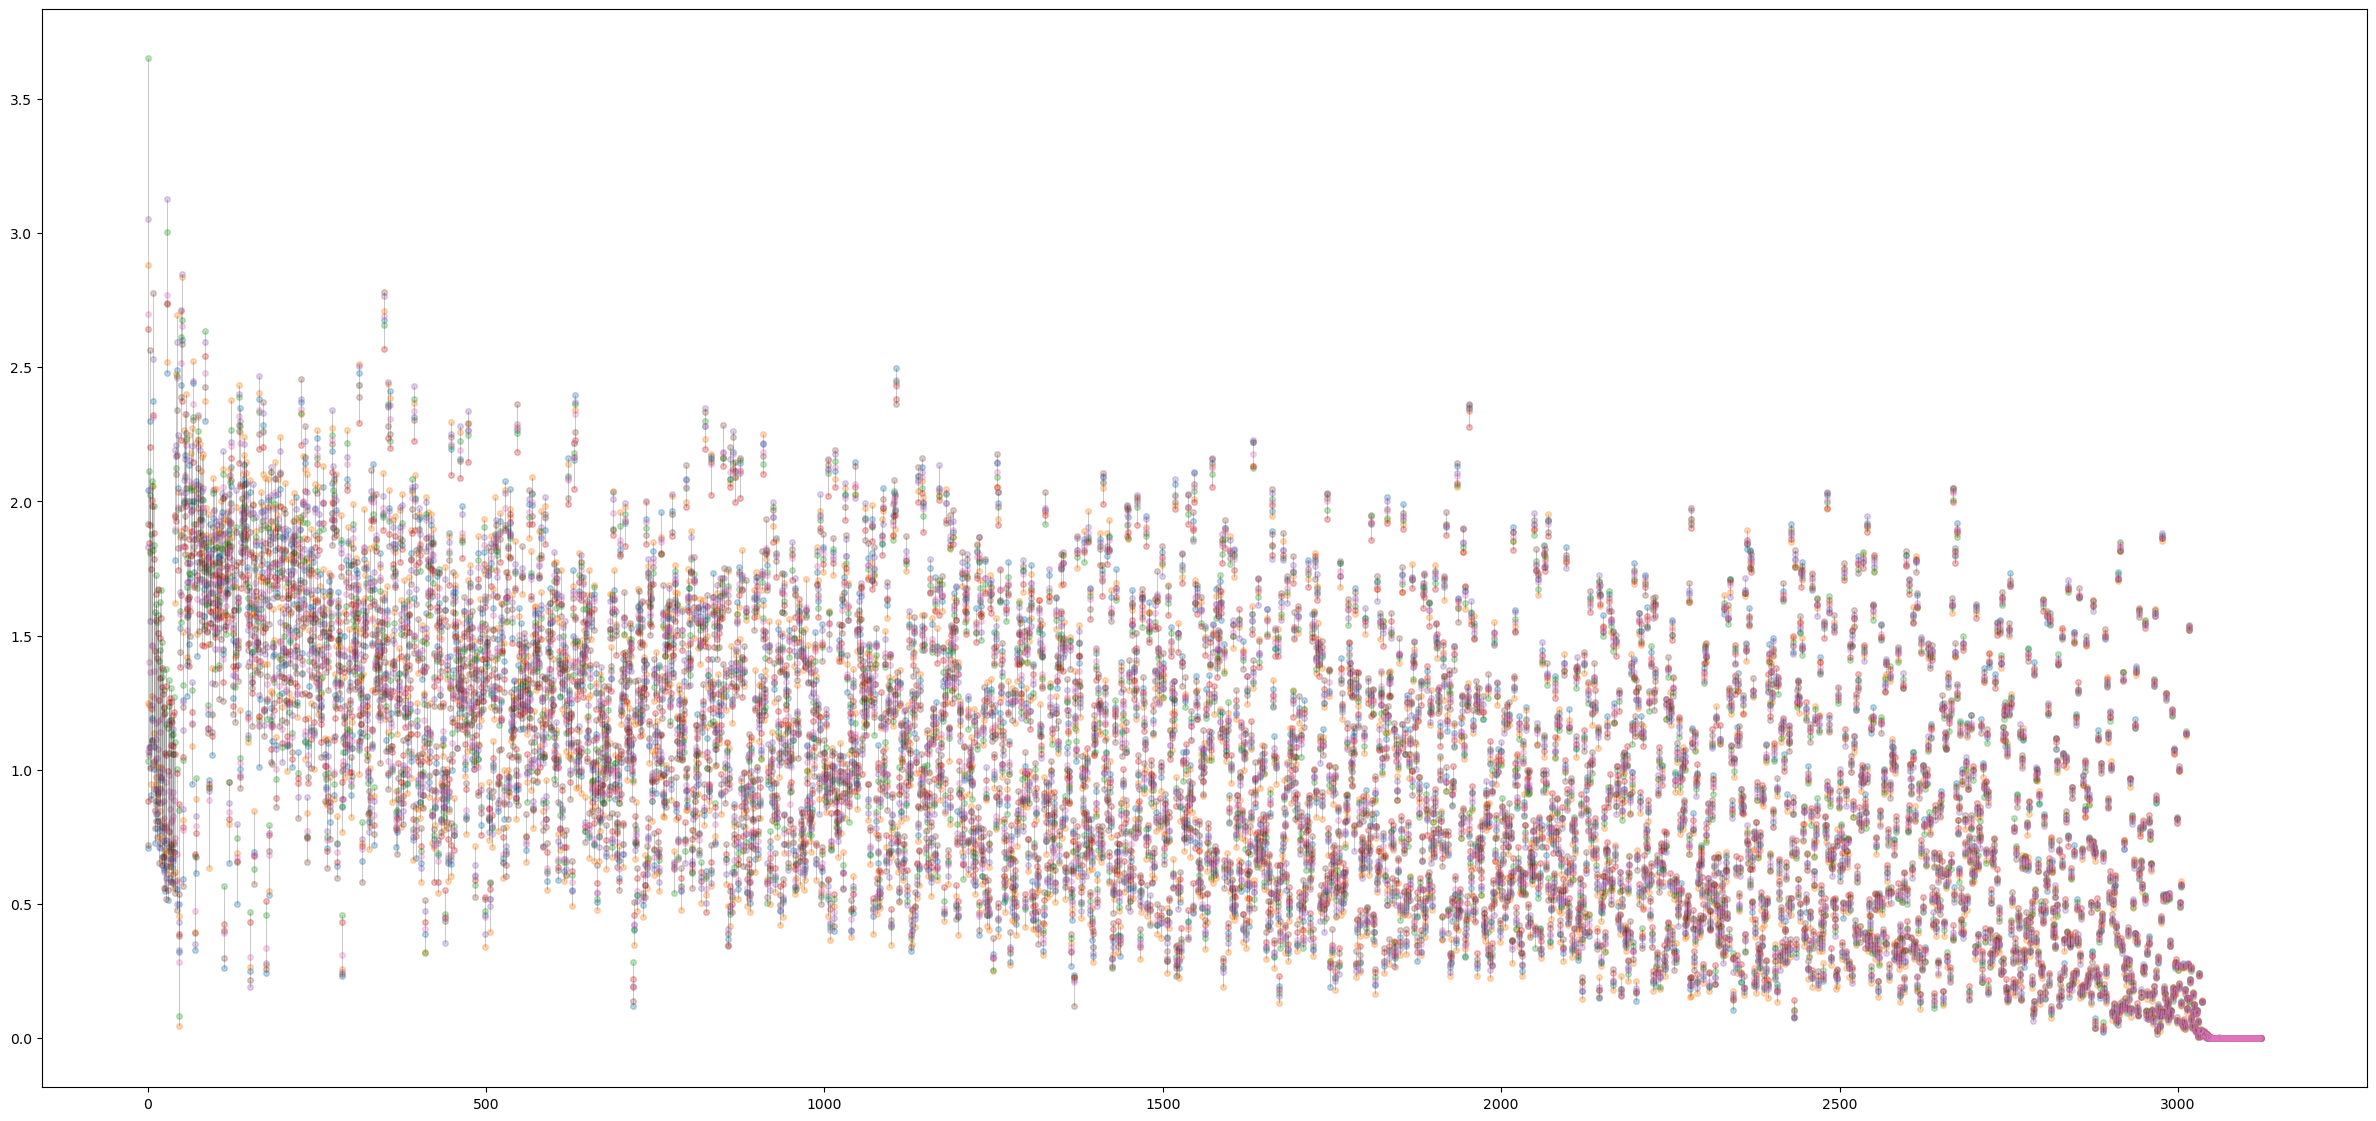

In [1235]:
# cols = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(norm_blood_panelseq_depth_grs)]
# means_df_subset = cbound_df.loc[:, [x for x in cbound_df.columns if x.endswith('_mean')]].iloc[:, :]
    
fig, ax = plt.subplots(figsize=(30, 14))
x = np.arange(merged_blood_depth_df.shape[0])
means_df = sorted_df.loc[:, [x for x in sorted_df.columns if x.endswith('norm_mean')]]
means_df_subset = means_df.iloc[:, :]
for (colname, column), color in zip(
    means_df_subset.items(),
    plt.rcParams['axes.prop_cycle'].by_key()['color'],
):
    ax.plot(x, column, color=color, linestyle='', marker='o', markersize=4, alpha=0.3)

ax.vlines(x=x, ymin=means_df_subset.apply(min, axis=1), ymax=means_df_subset.apply(max, axis=1), linewidth=0.5, alpha=0.3, color='black')

In [983]:
igv.cmd('new')
igv.load(list(blood_panelseq_bam_paths.values()))
igv.load([PANEL_REGION_EXONS_PATH, PANEL_REGION_INTRONS_PATH])

OK
OK
OK
OK
OK
OK
OK
OK
OK


In [1007]:
# row = cbound_df.iloc[1500, :]

selector = cbound_df.loc[:, [x for x in cbound_df.columns if x.endswith('_mean')]].apply(lambda x: all(x > 0), axis=1)
row = cbound_df.loc[selector, :].iloc[-1, :]

print(row)

locus = (row[0], row[1] - 100, row[2] + 100)
igv.goto([locus])
igv.cmd('squish')
igv.cmd('collapse "Refseq Genes"')

Chromosome           11
Start         108206900
End           108207145
GC              0.42449
S10_mean       0.000646
S6_mean        0.000728
S7_mean        0.001111
S9_mean        0.002195
S5_mean        0.000982
S8_mean        0.001916
Name: 878, dtype: object
OK
OK
OK


### Inspect baits with the least depths

In [1143]:
mean_cols_df = merged_blood_depth_df.loc[:, [x for x in merged_blood_depth_df.columns if x.endswith('_norm_mean')]]
sorted_df = merged_blood_depth_df.sort_values(by='merged_norm_mean', axis=0, ascending=False)
sorted_df = sorted_df.loc[mean_cols_df.apply(lambda x: all(x > 0), axis=1), :]

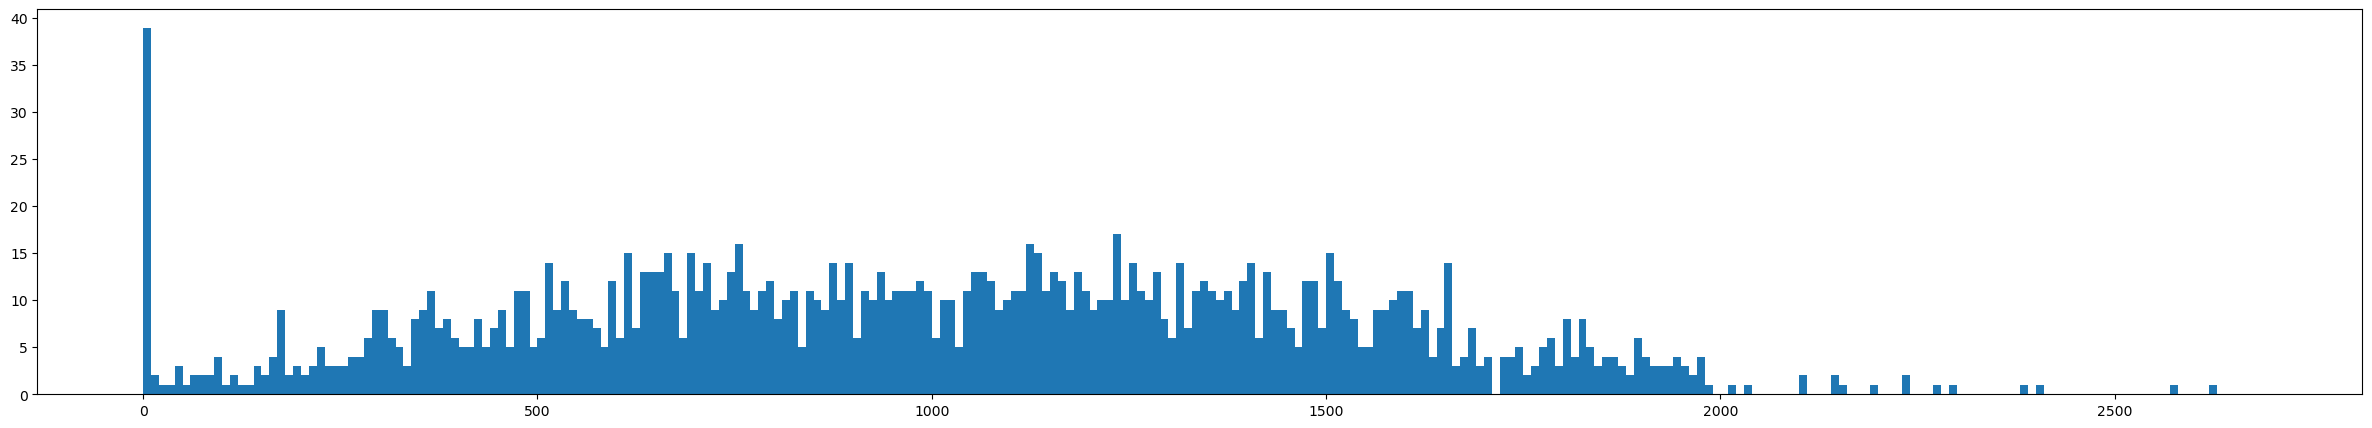

In [1145]:
data = merged_blood_depth_df.loc[:, [x for x in merged_blood_depth_df.columns if x.endswith('_mean') and not x.endswith('_norm_mean')]].apply(np.mean, axis=1)
fig, ax = plt.subplots(figsize=(30, 5))
_ = ax.hist(
    data, 
    bins=np.arange(0, np.ceil(data.max()), 10), 
    range=(0, 500),
)

In [1086]:
# row = cbound_df.iloc[1500, :]

row = sorted_df.iloc[-13, :]

print(row)

locus = (row.Chromosome, row.Start - 100, row.End + 100)
igv.goto([locus])
igv.cmd('collapse')
igv.cmd('collapse "Refseq Genes"')

Chromosome                12
Start               25403674
End                 25403880
S10_mean                49.2
S10_norm_mean       0.050458
S6_mean                69.31
S6_norm_mean        0.065503
S7_mean                60.92
S7_norm_mean         0.05785
S9_mean                46.49
S9_norm_mean        0.047906
S5_mean                52.84
S5_norm_mean        0.051895
S8_mean                56.87
S8_norm_mean        0.058264
merged_norm_mean    0.055313
GC                  0.762136
Name: 909, dtype: object
OK
OK
OK


### Create panel segments gr

In [1240]:
def draw_panelseq_depthratio(sampleid):
    panel_bam_path = BAM_PATHS['panel'][sampleid]
    panel_depth_gr = libmosdepth.run_mosdepth(panel_bam_path, t=5, region_bed_path=PANEL_REGION_FORDEPTH_PATH, donot_subset_bam=True)


    valid_indexes = (merged_blood_depth_df.merged_mean >= 50) & (panel_depth_gr.Mean >= 50)
    valid_merged_blood_depth_gr = pr.PyRanges(merged_blood_depth_df.loc[valid_indexes, :])
    valid_panel_depth_gr = panel_depth_gr[valid_indexes]
    valid_panel_depth_gr.norm_mean = list(valid_panel_depth_gr.Mean / valid_panel_depth_gr.Mean.mean())


    segment_gr = pr.PyRanges(chromosomes=valid_panel_depth_gr.Chromosome, starts=valid_panel_depth_gr.Start, ends=valid_panel_depth_gr.End)
    segment_gr.depth_ratio = list(valid_panel_depth_gr.norm_mean.array / valid_merged_blood_depth_gr.merged_norm_mean.array)


    subset_num = segment_gr.df.shape[0]
    segment_gr_subset = segment_gr[np.array([True] * subset_num + [False] * (segment_gr.df.shape[0] - subset_num))]
    widths = segment_gr_subset.End - segment_gr_subset.Start
    widths_cumsum = widths.cumsum()
    ys = segment_gr_subset.depth_ratio
    xmins = [0] + list(widths_cumsum[:-1])
    xmaxs = widths_cumsum

    fig, ax = plt.subplots(figsize=(30, 10))
    ax.hlines(y=ys, xmin=xmins, xmax=xmaxs)

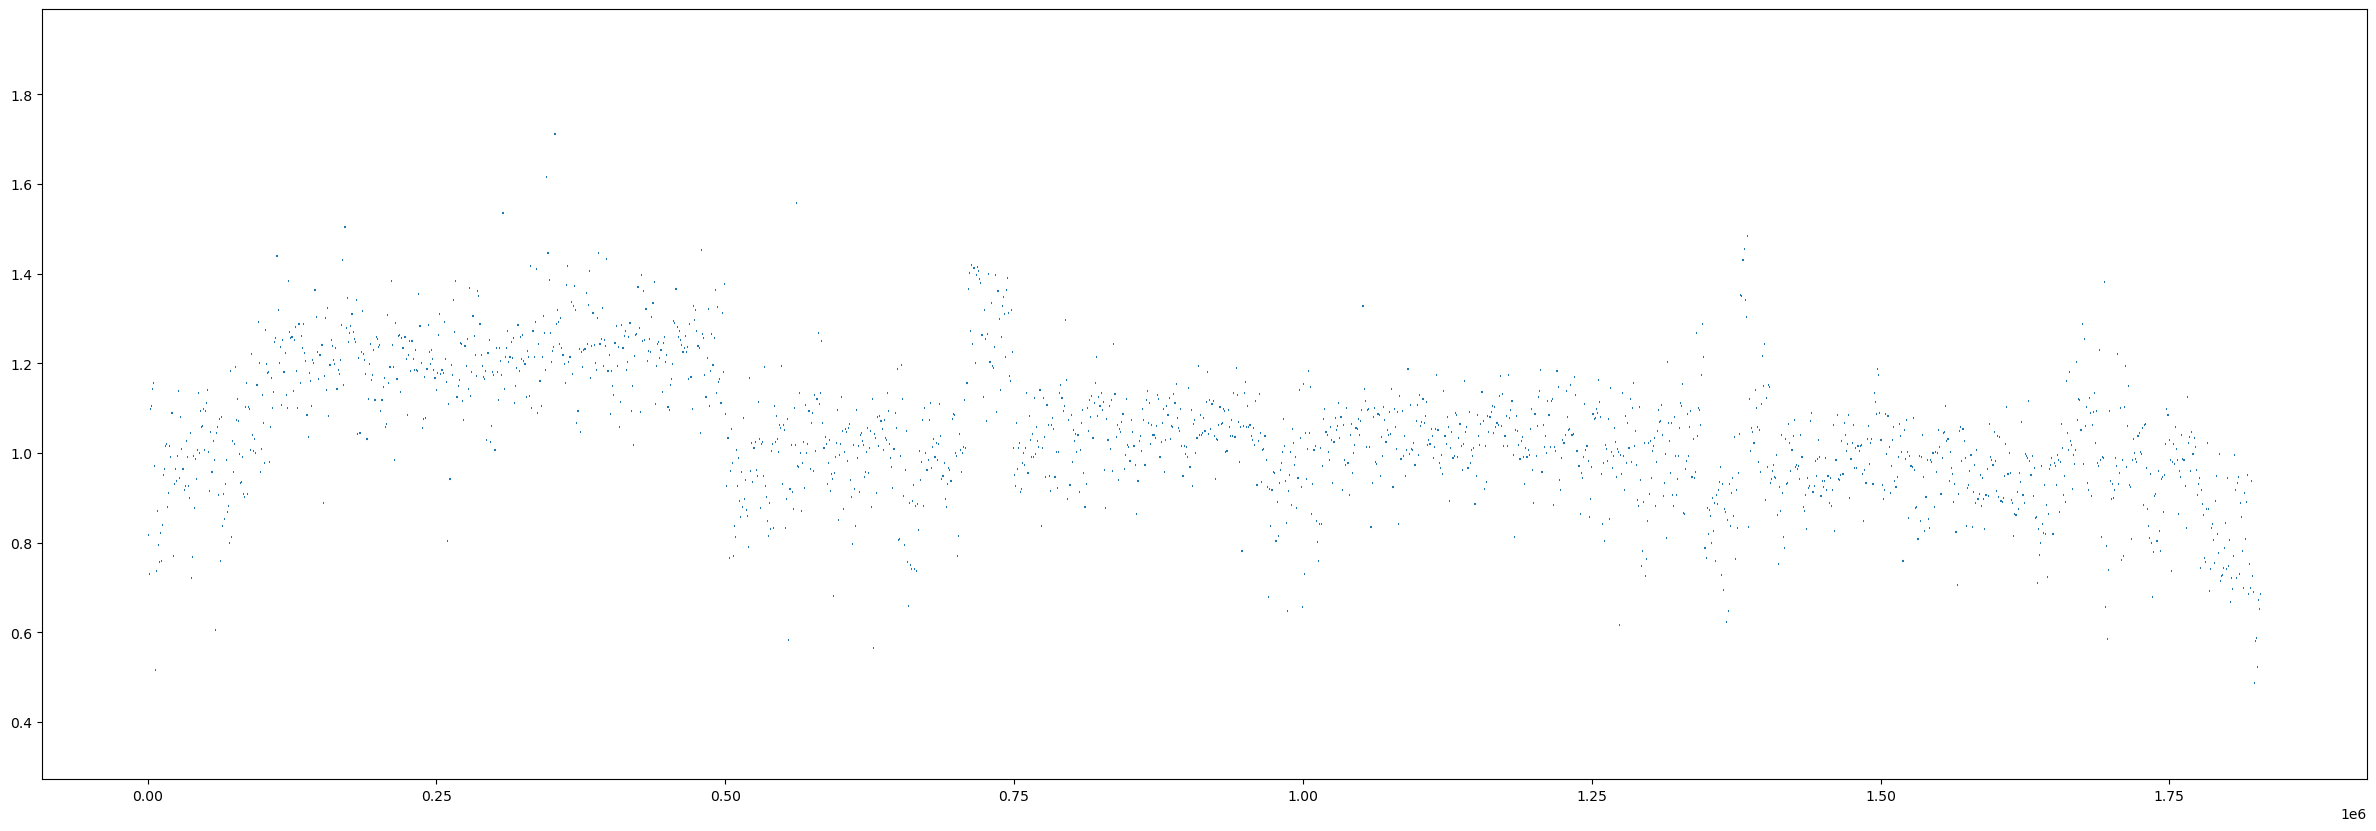

In [1241]:
draw_panelseq_depthratio('LU-14')

In [1458]:
sampleid = 'LU-14'
panel_bam_path = BAM_PATHS['panel'][sampleid]
panel_depth_gr = libmosdepth.run_mosdepth(panel_bam_path, t=5, region_bed_path=PANEL_REGION_FORDEPTH_PATH, donot_subset_bam=True)

In [1460]:
from handygenome.cnv.misc import postprocess_depth_df, get_gc_depth_data

In [ ]:
gr = merged_blood_panelseq_gr

In [1465]:
panel_depth_df = postprocess_depth_df(gr.df, FASTA_HG19)

In [1522]:
df = gr.df.copy()
add_gc_to_df(df, FASTA_HG19)
gcbin_average_depths, gcbin_norm_average_depths, cutresult = get_gc_depth_data(df, n_bin=50)

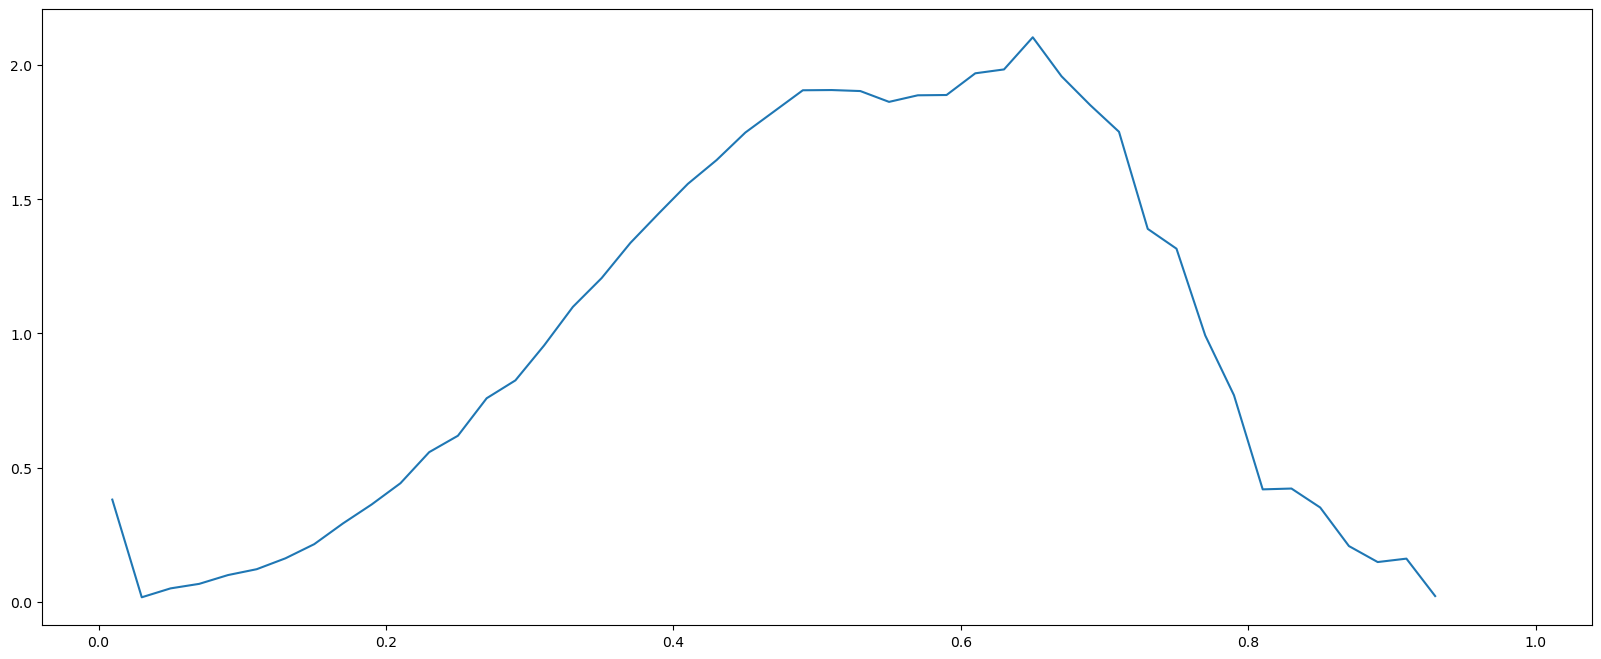

In [1523]:
fig, ax = plt.subplots(figsize=(20, 8))
x = gcbin_norm_average_depths.index.mid
y = gcbin_norm_average_depths.array
ax.plot(x, y)

In [1378]:
panel_depth_gr.norm_mean = panel_depth_gr.Mean / panel_depth_gr.Mean.mean()

segment_gr = pr.PyRanges(chromosomes=panel_depth_gr.Chromosome, starts=panel_depth_gr.Start, ends=panel_depth_gr.End)
segment_gr.depth_ratio = list(panel_depth_gr.norm_mean.array / merged_blood_depth_df.merged_norm_mean.array)
add_gc_to_gr(segment_gr, FASTA_HG19)

In [1379]:
cnvkit_segment_df = pd.read_csv(cnvkit_segment_path_dict[sampleid], sep='\t', header=0)
cnvkit_segment_df = cnvkit_segment_df.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
cnvkit_segment_df['seg_depthratio'] = 2 ** cnvkit_segment_df['log2']
cnvkit_segment_df['seg_depthratio_ci_lo'] = 2 ** cnvkit_segment_df['ci_lo']
cnvkit_segment_df['seg_depthratio_ci_hi'] = 2 ** cnvkit_segment_df['ci_hi']

cnvkit_segment_gr = pr.PyRanges(cnvkit_segment_df)

In [1381]:
segment_gr = segment_gr.join(cnvkit_segment_gr[[x for x in cnvkit_segment_gr.columns if x.startswith('seg_')]], how='left')

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/methods/join.py:71: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  h2.loc[:, n] = null
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/home/users/pjh/tools/minic

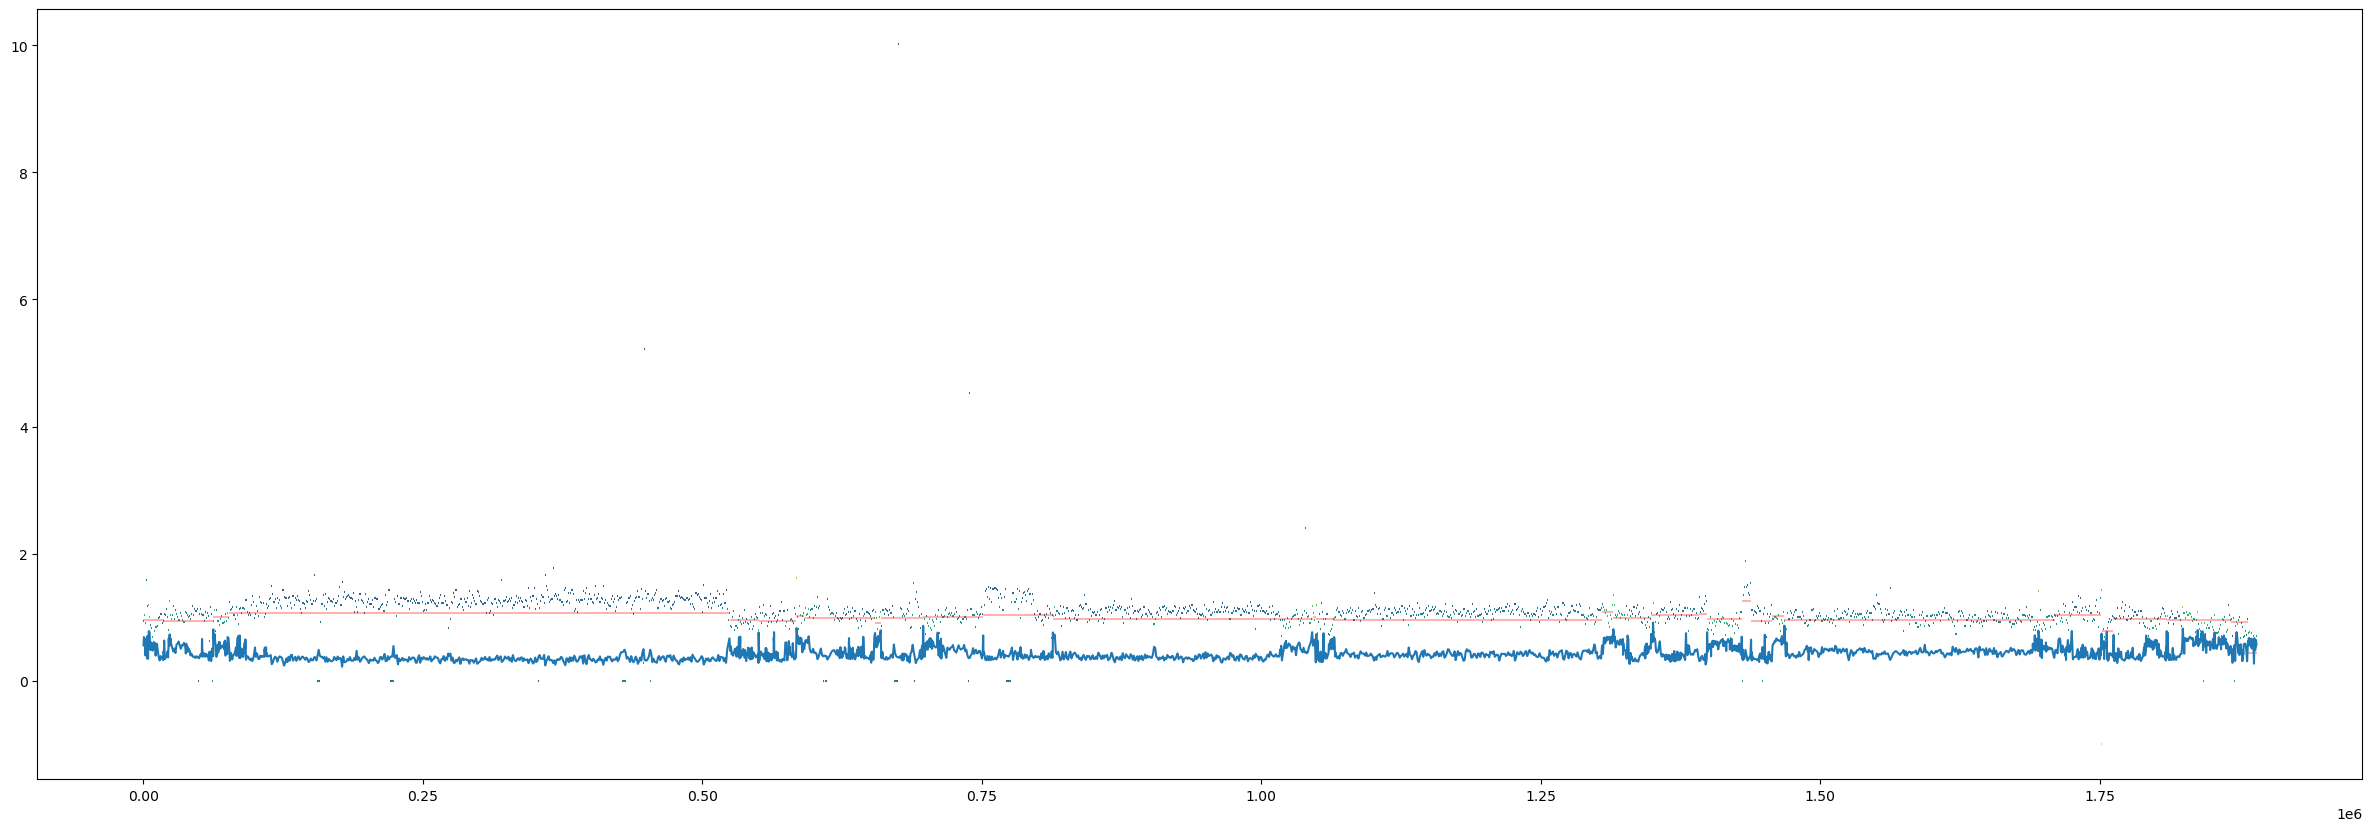

In [1384]:
subset_num = segment_gr.df.shape[0]
segment_gr_subset = segment_gr[np.array([True] * subset_num + [False] * (segment_gr.df.shape[0] - subset_num))]
widths = segment_gr_subset.End - segment_gr_subset.Start
widths_cumsum = widths.cumsum()

xmin = [0] + list(widths_cumsum.iloc[:-1])
xmax = widths_cumsum

fig, ax = plt.subplots(figsize=(30, 10))
ax.hlines(y=segment_gr_subset.depth_ratio, xmin=xmin, xmax=xmax, colors=mpl.colormaps['viridis'](segment_gr_subset.GC))
ax.hlines(y=segment_gr_subset.seg_depthratio, xmin=xmin, xmax=xmax, color='red', alpha=0.3)
ax.plot((xmin + xmax) / 2, segment_gr_subset.GC)

# ax.axhline(y=1, color='green', alpha=0.3)

# Copynumber call validation

In [170]:
cnvfig_dir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/25_cnv_plots'
final_segments_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/26_cnv_segments'

### extract, fit file paths

In [10]:
import re

SEQUENZA_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/05_sequenza'

EXTRACT_PATHS = dict()
FIT_PATHS = dict()

for top, dirs, files in os.walk(SEQUENZA_TOPDIR):
    for f in files:
        if re.search(r'_extract\.', f):
            sampleid = 'LU-' + f.split('_')[0]
            if sampleid in SAMPLEIDS_LU:
                EXTRACT_PATHS[sampleid] = os.path.join(top, f)
        if re.search(r'_cp_table\.', f):
            sampleid = 'LU-' + f.split('_')[0]
            if sampleid in SAMPLEIDS_LU:
                FIT_PATHS[sampleid] = os.path.join(top, f)
                

### depth file paths

In [11]:
import re

DEPTH_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/quick_results'
TUMOR_DEPTH_PATHS = dict()
NORMAL_DEPTH_PATHS = dict()

for top, dirs, files in os.walk(DEPTH_TOPDIR):
    for f in files:
        if f.endswith('regions.bed.gz'):
            sampleid = f.split('.')[0]
            if sampleid in SAMPLEIDS_LU:
                if 'normal' in f:
                    NORMAL_DEPTH_PATHS[sampleid] = os.path.join(top, f)
                if 'tumor' in f:
                    TUMOR_DEPTH_PATHS[sampleid] = os.path.join(top, f)


### Main

In [13]:
sampleid = 'LU-SC88'
# sampleid = SAMPLEIDS_LU[12]
print(sampleid)


seg_cache = dict()
fig_cache = dict()

is_female = IS_FEMALE[sampleid]

extract_file_path = EXTRACT_PATHS[sampleid]
extract = sequenza_handler.load_extract(extract_file_path, CHROMDICT_HG19, as_gr=False)
extract_gr = pr.PyRanges(extract)

fitfile_path = FIT_PATHS[sampleid]
fitresult = sequenza_handler.load_fit(fitfile_path)

tumor_depth_path = TUMOR_DEPTH_PATHS[sampleid]
normal_depth_path = NORMAL_DEPTH_PATHS[sampleid]
tumor_depth = read_cnvfile.read_depth_bed(tumor_depth_path)
normal_depth = read_cnvfile.read_depth_bed(normal_depth_path)

solutions = sequenza_handler.get_fitresult_peaks(fitresult)

LU-SC88


In [14]:
solutions

[{'ploidy': 1.5, 'cellularity': 0.12, 'lpp': 0.22128453884055},
 {'ploidy': 2.0, 'cellularity': 0.44, 'lpp': 3.35446235251274e-34},
 {'ploidy': 5.4, 'cellularity': 0.15, 'lpp': 1.38286114778864e-41}]

### Visualization of fit result

In [18]:
all_vals = fitresult.to_numpy().flatten()
fitresult_quantile = fitresult.applymap(lambda x: (all_vals < x).mean())

<AxesSubplot: xlabel='cellularity', ylabel='ploidy'>

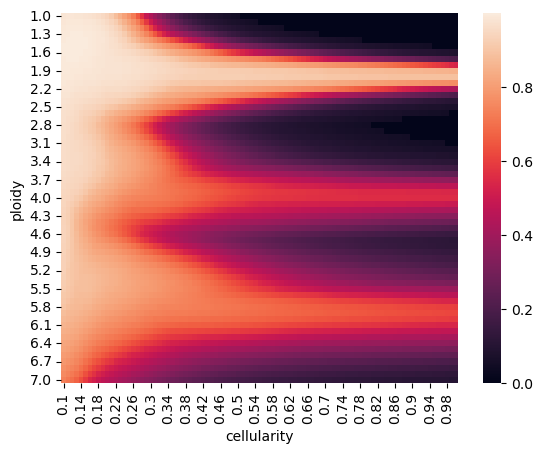

In [25]:
sns.heatmap(fitresult_quantile)

In [59]:
fitresult.index[fitresult.loc[:, 0.24].argmax()]

1.8

### prepare segments df

In [46]:
sol = solutions[1]
cellularity = sol['cellularity']
ploidy = sol['ploidy']

In [60]:
cellularity = 0.24
ploidy = 1.8

In [61]:
print('preparing segments df')
print('cellularity', cellularity, 'ploidy', ploidy)

key = (cellularity, ploidy)
if key not in seg_cache.keys():
    seg_cache[key] = sequenza_handler.make_segments_as_df(extract_file_path, cellularity, ploidy, is_female)

# seg_gr = pr.PyRanges(seg)

preparing segments df
cellularity 0.24 ploidy 1.8


### Pick cp and draw plot

In [62]:
from handygenome.cnv import misc as cnvmisc

# cellularity = 0.29
# ploidy = 3.7

print('cellularity', cellularity, 'ploidy', ploidy)

key = (cellularity, ploidy)
seg = seg_cache[key]

calculated_ploidy = round(cnvmisc.get_mean_ploidy(seg), 1)
print(f'calculated_ploidy: {calculated_ploidy}')

cellularity 0.24 ploidy 1.8
calculated_ploidy: 1.8


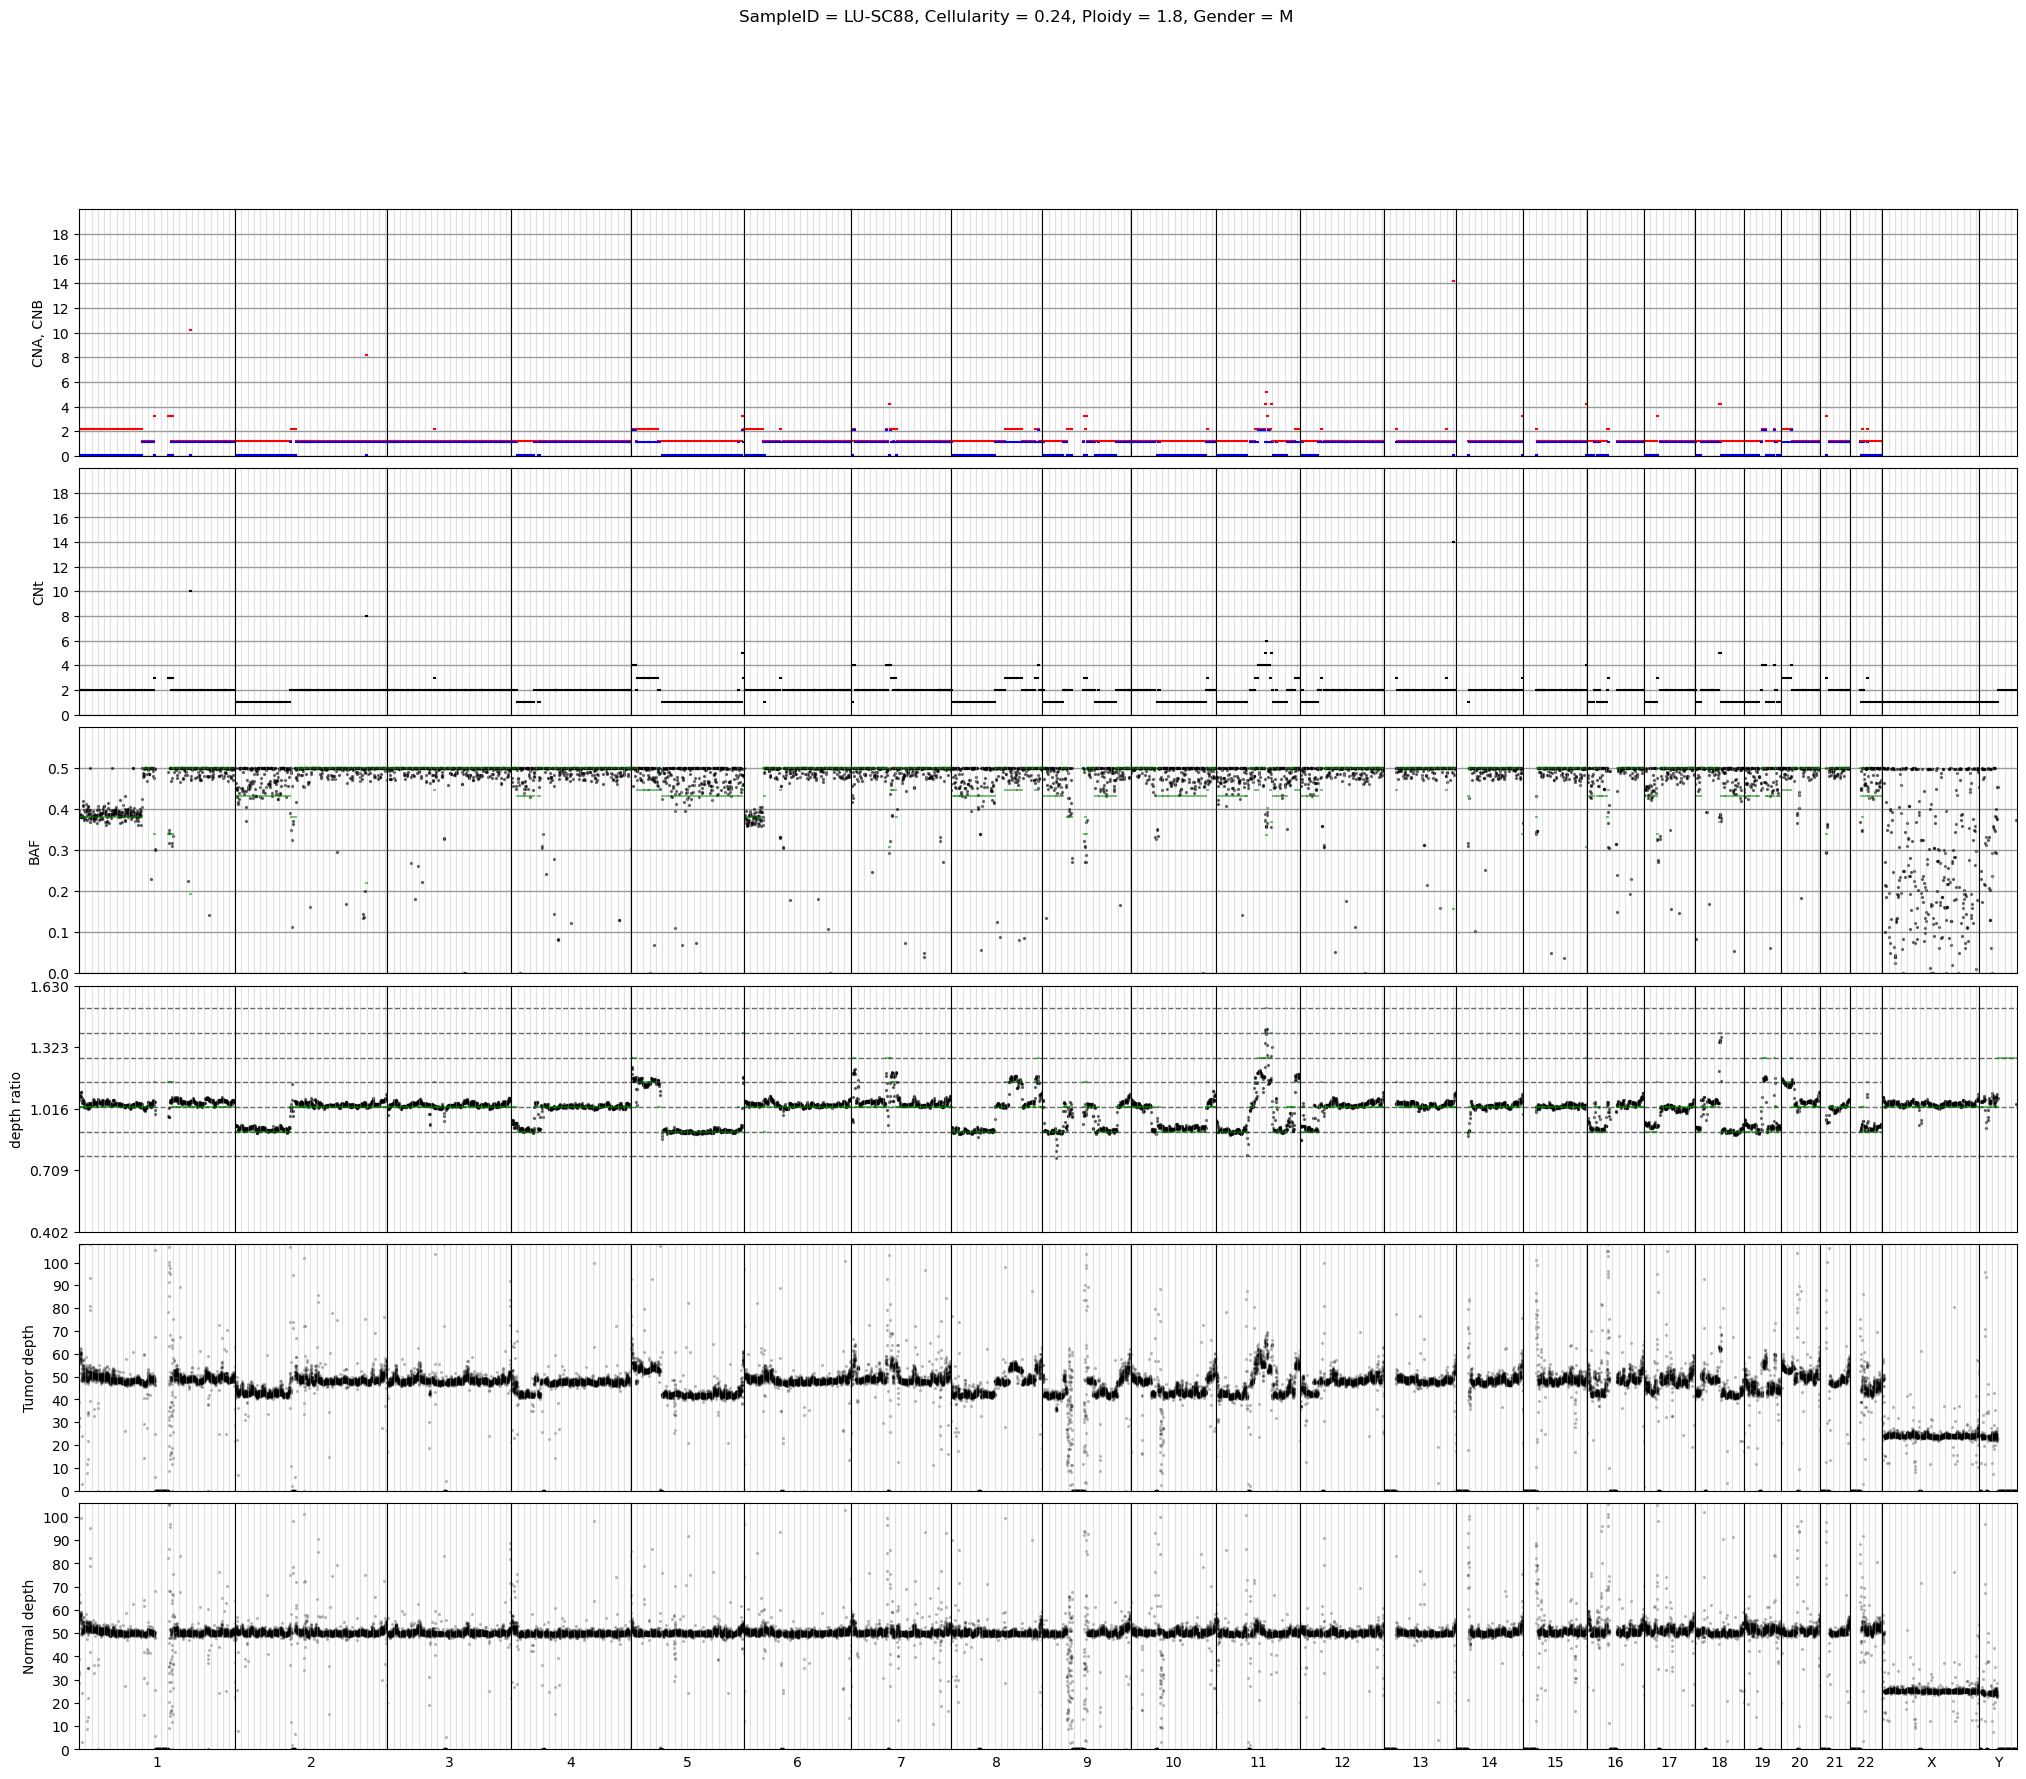

In [63]:
# if key not in fig_cache:
#     fig_cache[key] = inspect_cnv.draw_CNVcall(extract, seg, tumor_depth, normal_depth, cellularity, ploidy, is_female, chromdict=CHROMDICT_HG19, sampleid=sampleid, figsize=(25, 20))
    
fig_cache[key] = inspect_cnv.draw_CNVcall(extract, seg, tumor_depth, normal_depth, cellularity, ploidy, is_female, chromdict=CHROMDICT_HG19, sampleid=sampleid, figsize=(25, 20))
fig = fig_cache[key]
# fig.savefig(os.path.join(cnvfig_dir, f'{sampleid}_c{cellularity}_p{ploidy}_cnvplot.pdf'))

### Save segments file for determined solution

In [315]:
cellularity = 0.88
ploidy = 2.4
key = (cellularity, ploidy)
segments_path = os.path.join(final_segments_topdir, f'{sampleid}_c{cellularity}_p{ploidy}_segments.tsv.gz')
seg = seg_cache[key]
seg.to_csv(segments_path, sep='\t', index=False)